In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

def remove_unwanted_folders(root, unwanted_folders=["Br35H-Mask-RCNN"]):
    for uf in unwanted_folders:
        for subdir, dirs, files in os.walk(root):
            path_to_remove = os.path.join(subdir, uf)
            if os.path.exists(path_to_remove):
                shutil.rmtree(path_to_remove)
                print(f"Removed {path_to_remove}")

# Apply to BR35H
br_root = "/content/drive/MyDrive/Data/Br35H"
remove_unwanted_folders(br_root)


In [ ]:
for root, dirs, files in os.walk(br_root):
    print(root, dirs)


/content/drive/MyDrive/Data/Br35H ['pred', 'train', 'test']
/content/drive/MyDrive/Data/Br35H/pred []
/content/drive/MyDrive/Data/Br35H/train ['tumor', 'no_tumor']
/content/drive/MyDrive/Data/Br35H/train/tumor []
/content/drive/MyDrive/Data/Br35H/train/no_tumor []
/content/drive/MyDrive/Data/Br35H/test ['tumor', 'no_tumor']
/content/drive/MyDrive/Data/Br35H/test/tumor []
/content/drive/MyDrive/Data/Br35H/test/no_tumor []


In [ ]:
import os

br_root = "/content/drive/MyDrive/Data/Br35H"

for split in ['train', 'test']:
    for cls in ['tumor', 'no_tumor']:
        os.makedirs(os.path.join(br_root, split, cls), exist_ok=True)

print("Folder structure created!")


Folder structure created!


In [ ]:
import glob
import shutil
import random

# Example for yes -> tumor
yes_images = glob.glob(os.path.join(br_root, "yes", "*.*"))
random.shuffle(yes_images)
split_idx = int(0.8 * len(yes_images))

for img in yes_images[:split_idx]:
    shutil.move(img, os.path.join(br_root, "train", "tumor"))
for img in yes_images[split_idx:]:
    shutil.move(img, os.path.join(br_root, "test", "tumor"))

# Example for no -> no_tumor
no_images = glob.glob(os.path.join(br_root, "no", "*.*"))
random.shuffle(no_images)
split_idx = int(0.8 * len(no_images))

for img in no_images[:split_idx]:
    shutil.move(img, os.path.join(br_root, "train", "no_tumor"))
for img in no_images[split_idx:]:
    shutil.move(img, os.path.join(br_root, "test", "no_tumor"))


In [ ]:
for split in ['train', 'test']:
    for cls in ['tumor', 'no_tumor']:
        path = os.path.join(br_root, split, cls)
        print(path, ":", os.listdir(path)[:5])  # shows first 5 images


/content/drive/MyDrive/Data/Br35H/train/tumor : ['y1214.jpg', 'y1215.jpg', 'y1197.jpg', 'y1190.jpg', 'y1211.jpg']
/content/drive/MyDrive/Data/Br35H/train/no_tumor : ['no1227.jpg', 'no1243.jpg', 'no1309.jpg', 'no1255.jpg', 'no1284.jpg']
/content/drive/MyDrive/Data/Br35H/test/tumor : ['y1035.jpg', 'y1106.jpg', 'y1052.jpg', 'y1022.jpg', 'y1040.jpg']
/content/drive/MyDrive/Data/Br35H/test/no_tumor : ['no1034.jpg', 'No17.jpg', 'no1013.jpg', 'no1002.jpg', 'no1001.jpg']


In [ ]:
# Setup paths and device
# Assumes Google Drive is mounted at /content/drive
br_root = "/content/drive/MyDrive/Data/Br35H"  # BR35H dataset root (Training data)
btd_root = "/content/drive/MyDrive/Data/Brain Tumor Data"  # BTD dataset root (Test data)
checkpoint_dir = "/content/drive/MyDrive/Journal_paper"
RESULTS_FOLDER = os.path.join(checkpoint_dir, "results")
os.makedirs(RESULTS_FOLDER, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Results will be saved to: {RESULTS_FOLDER}")
print(f"Using device: {device}")

Results will be saved to: /content/drive/MyDrive/Journal_paper/results
Using device: cuda


In [ ]:
# --- Cell 2: Data Loaders and Transformations (Adapted from original notebook) ---

img_size = 224

# Transformations (using the existing scheme for consistency)
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load BR35H (Training/Source Domain)
br_train_ds = datasets.ImageFolder(f"{br_root}/train", transform=train_tfms)

# Load BTD (Testing/Target Domain)
btd_test_ds = datasets.ImageFolder(f"{btd_root}/test", transform=test_tfms)

# Binary Mapping for BTD (assumed from the original notebook's evaluation section)
# This maps the 4 original classes to 2 binary classes (e.g., 0: No Tumor, 1: Tumor)
# This mapping needs adjustment if the original notebook's labels differ from BTD's standard 4 classes.
# Assuming BTD labels are: [0, 1, 2, 3] -> [1, 1, 0, 1] for [Tumor, Tumor, No_Tumor, Tumor]
btd_label_map = {0: 1, 1: 1, 2: 0, 3: 1} # Adjusted to map 4-class BTD to 2-class binary

# Helper class for Binary BTD Dataset
class BinaryBTDDataset(Dataset):
    def __init__(self, original_dataset, mapped_labels):
        self.dataset = original_dataset
        self.labels = mapped_labels
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, self.labels[idx]

btd_test_labels = [btd_label_map.get(label, 0) for _, label in btd_test_ds.imgs] # Use .get with default 0 just in case
test_ds_binary = BinaryBTDDataset(btd_test_ds, btd_test_labels)

# DataLoaders
train_loader = DataLoader(br_train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader_binary = DataLoader(test_ds_binary, batch_size=32, shuffle=False, num_workers=2)

num_classes = 2 # Forced to 2 classes for ROC/AUC/Binary metrics
print(f"Number of classes: {num_classes}")
print(f"Training images: {len(br_train_ds)}")
print(f"BTD binary test images: {len(test_ds_binary)}")

Number of classes: 2
Training images: 2400
BTD binary test images: 1311


In [ ]:
# --- 📦 Fast Dataset Visualization: BR35H (Train) & BTD (Test) ---
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from torch.utils.data import DataLoader

# === Folder to save visualization outputs ===
save_dir = "/content/drive/MyDrive/Journal_paper/dataset_visualizations"
os.makedirs(save_dir, exist_ok=True)

# === Helper: Unnormalize tensor image for display ===
def unnormalize(img_tensor):
    img = img_tensor.clone()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    return torch.clamp(img, 0, 1)

# === Helper: Visualize sample images (FAST MODE) ===
def visualize_samples(loader, class_names, dataset_name, save_dir, n_samples=8):
    # Get one batch only
    data_iter = iter(loader)
    images, labels = next(data_iter)

    n_samples = min(n_samples, len(images))
    fig, axes = plt.subplots(2, n_samples//2, figsize=(14, 6))
    fig.suptitle(f"Sample Images from {dataset_name}", fontsize=16)

    for i in range(n_samples):
        ax = axes[i//(n_samples//2), i%(n_samples//2)]
        img = unnormalize(images[i])
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"Class: {class_names[labels[i].item()]}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    save_path = os.path.join(save_dir, f"{dataset_name}_samples.png")
    plt.savefig(save_path)
    plt.close()
    print(f"✅ Saved {dataset_name} sample images → {save_path}")

# === Helper: Class distribution plot ===
def plot_class_distribution(dataset, class_names, dataset_name, save_dir):
    if hasattr(dataset, "targets"):  # For ImageFolder
        labels = dataset.targets
    elif hasattr(dataset, "labels"):  # For Binary BTD wrapper
        labels = dataset.labels
    else:
        labels = [label for _, label in dataset]

    label_counts = Counter(labels)
    plt.figure(figsize=(6,5))
    sns.barplot(
        x=[class_names[i] for i in label_counts.keys()],
        y=list(label_counts.values()),
        palette="Set2"
    )
    plt.title(f"{dataset_name} - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.tight_layout()

    save_path = os.path.join(save_dir, f"{dataset_name}_class_distribution.png")
    plt.savefig(save_path)
    plt.close()
    print(f"✅ Saved {dataset_name} class distribution → {save_path}")

# === Helper: Compare BR35H vs BTD distributions ===
def compare_distributions(train_dataset, test_dataset, class_names, save_dir):
    train_counts = Counter(train_dataset.targets)
    test_counts = Counter(test_dataset.labels)

    data = {
        "Class": [class_names[c] for c in range(len(class_names))] * 2,
        "Count": [train_counts.get(i,0) for i in range(len(class_names))] +
                 [test_counts.get(i,0) for i in range(len(class_names))],
        "Dataset": ["BR35H (Train)"]*len(class_names) + ["BTD (Test)"]*len(class_names)
    }

    plt.figure(figsize=(8,6))
    sns.barplot(x="Class", y="Count", hue="Dataset", data=data, palette="pastel")
    plt.title("Comparison: BR35H (Train) vs BTD (Test)")
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.tight_layout()

    save_path = os.path.join(save_dir, "comparison_BR35H_vs_BTD.png")
    plt.savefig(save_path)
    plt.close()
    print(f"✅ Saved comparison plot → {save_path}")

# === Create faster preview DataLoaders ===
train_loader_fast = DataLoader(br_train_ds, batch_size=8, shuffle=True, num_workers=0)
test_loader_fast = DataLoader(test_ds_binary, batch_size=8, shuffle=False, num_workers=0)

# === Class names ===
btd_classes = ["No Tumor", "Tumor"]

# === Run all visualizations ===
print("📊 Generating dataset visualizations...")

# BR35H train visualization
visualize_samples(train_loader_fast, br_train_ds.classes, "BR35H_Train", save_dir)
plot_class_distribution(br_train_ds, br_train_ds.classes, "BR35H_Train", save_dir)

# BTD binary test visualization
visualize_samples(test_loader_fast, btd_classes, "BTD_Binary_Test", save_dir)
plot_class_distribution(test_ds_binary, btd_classes, "BTD_Binary_Test", save_dir)

# Comparison between BR35H (Train) and BTD (Test)
compare_distributions(br_train_ds, test_ds_binary, btd_classes, save_dir)

print(f"\n🎯 All visualizations saved successfully to → {save_dir}")


📊 Generating dataset visualizations...


KeyboardInterrupt: 

In [ ]:
# Evaluation Function (Copied from original notebook)
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs_positive = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Use softmax output for ROC/AUC (probability of class 1/tumor)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs_positive.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_probs_positive": y_probs_positive
    }

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def fine_tune_model(model, few_shot_loader, epochs=10, lr=1e-5):
    model.train()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(few_shot_loader, desc=f"Fine-tune Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(few_shot_loader):.4f}")

    return model


In [ ]:
# Model Getter (Adapted to include .name attribute and MixStyle support for multiple architectures)
def get_model(name, num_classes=2, use_mixstyle=False):


        # Substitute with ViT Small (closest architecture in timm)
        model = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
        base_name = "medvit"
    else:
        # All normal models
        model = timm.create_model(name, pretrained=True, num_classes=num_classes)
        base_name = name

    model.name = base_name


    if use_mixstyle:

        # ----- ResNet -----
        if "resnet" in base_name and hasattr(model, "layer1"):
            model.layer1[0].bn1 = nn.Sequential(model.layer1[0].bn1,
                                                MixStyle(p=0.5, alpha=0.1))

        # ----- MobileNetV2 -----
        if "mobilenetv2" in base_name and hasattr(model, "features"):
            model.features[0][0] = nn.Sequential(model.features[0][0],
                                                 MixStyle(p=0.5, alpha=0.1))

        # ----- ConvNeXt -----
        if "convnext" in base_name and hasattr(model, "stages"):
            first_block = model.stages[0].blocks[0]
            first_block.norm = nn.Sequential(first_block.norm,
                                             MixStyle(p=0.5, alpha=0.1))

        # ----- Swin Transformer -----
        if "swin" in base_name and hasattr(model, "layers"):
            blk = model.layers[0].blocks[0]
            blk.norm1 = nn.Sequential(blk.norm1,
                                      MixStyle(p=0.5, alpha=0.1))

        # ----- DenseNet -----
        if "densenet" in base_name and hasattr(model, "features"):
            model.features.norm0 = nn.Sequential(model.features.norm0,
                                                 MixStyle(p=0.5, alpha=0.1))

        # ----- MedViT Substitute (ViT-Small) -----
        if "medvit" in base_name:
            # Add MixStyle into ViT patch embedding (like token-level augmentation)
            if hasattr(model, "patch_embed"):
                model.patch_embed.proj = nn.Sequential(model.patch_embed.proj,
                                                       MixStyle(p=0.5, alpha=0.1))
            # Add to first transformer block norm
            if hasattr(model, "blocks"):
                blk = model.blocks[0]
                blk.norm1 = nn.Sequential(blk.norm1, MixStyle(p=0.5, alpha=0.1))

        model.name = f"{base_name}_mixstyle"

    else:
        model.name = f"{base_name}_baseline"

    return model


In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def train_model(
    model, train_loader, test_loader,
    model_name, use_mixstyle=False,
    epochs=50, patience=7, fine_tune=False,
    lr=1e-5, checkpoint_dir="/content/drive/MyDrive/Journal_paper/checkpoints"
):
    """
    Train a model with optional MixStyle, fine-tuning, early stopping, and checkpoint saving.
    Works for architectures: ResNet, DenseNet, ConvNeXt, Swin, MobileNet, MedViT.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(checkpoint_dir, exist_ok=True)
    model = model.to(device)

    print(f"\n🚀 Starting training: {model_name} | MixStyle: {use_mixstyle} | Fine-tune: {fine_tune}")


    # Fine-tuning mode: freeze backbone, train only classifier head

    if fine_tune:
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze classifier or final FC layer depending on architecture
        if hasattr(model, "fc"):  # ResNet
            for param in model.fc.parameters():
                param.requires_grad = True
        elif hasattr(model, "classifier"):  # MobileNet / DenseNet / ConvNeXt
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif hasattr(model, "head"):  # Swin / MedViT
            for param in model.head.parameters():
                param.requires_grad = True

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        print("🧩 Fine-tuning only the classifier head.")
    else:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("🎯 Training full model (all parameters trainable).")

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"📉 Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f}")

        # Step scheduler
        scheduler.step(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path = f"{checkpoint_dir}/{model_name}_best.pth"
            torch.save(best_model_wts, save_path)
            print(f"✅ Saved new best checkpoint: {save_path}")
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"⏹ Early stopping triggered at epoch {epoch+1}.")
                break

    model.load_state_dict(best_model_wts)

    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print("\n📊 Evaluation Results:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm
    }


In [ ]:

# Grad-CAM for Transformer and CNN Models

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms


def grad_cam(model, image, target_class=None, layer_name=None, device=None):
    """
    Generalized Grad-CAM for Vision Transformers (ViT, Swin, MedViT) and CNN hybrids.
    Args:
        model: torch.nn.Module - pretrained model
        image: torch.Tensor - single input image tensor (C, H, W)
        target_class: int - optional target class index
        layer_name: str - layer to hook for activations (e.g., "blocks.11.norm1" for ViT, "layers.3.blocks.1.norm1" for Swin)
        device: torch.device - CUDA or CPU
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval().to(device)
    image = image.unsqueeze(0).to(device)

    gradients, activations = {}, {}


    def save_gradients(module, grad_input, grad_output):
        gradients['value'] = grad_output[0]

    def save_activations(module, input, output):
        activations['value'] = output


    if layer_name is None:
        possible_layers = [n for n, m in model.named_modules() if "norm" in n or "blocks" in n]
        layer_name = possible_layers[-1] if possible_layers else list(model.named_modules())[-1][0]
        print(f"⚙️ Using automatically detected layer: {layer_name}")

    layer = dict([*model.named_modules()]).get(layer_name, None)
    if layer is None:
        raise ValueError(f"❌ Layer '{layer_name}' not found in model. Check model.named_modules().")

    # Register forward and backward hooks
    fwd_hook = layer.register_forward_hook(save_activations)
    bwd_hook = layer.register_full_backward_hook(save_gradients)


    # Forward and backward passes

    outputs = model(image)
    if target_class is None:
        target_class = outputs.argmax().item()

    model.zero_grad()
    outputs[0, target_class].backward()


    # Extract data

    grad = gradients['value'].detach().cpu().numpy()[0]
    act = activations['value'].detach().cpu().numpy()[0]

    # Weight each channel by mean gradient
    weights = grad.mean(axis=(1, 2)) if grad.ndim == 3 else grad.mean(axis=0)
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    cam_resized = cv2.resize(cam, (image.shape[3], image.shape[2]))

    img_np = image[0].detach().cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = 0.5 * heatmap / 255.0 + 0.5 * img_np

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM | Target Class: {target_class} | Layer: {layer_name}")
    plt.axis("off")
    plt.show()

    # Clean up hooks
    fwd_hook.remove()
    bwd_hook.remove()

    return cam_resized, overlay


In [ ]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [
    "resnet50",
    "mobilenetv2_100",
    "convnext_tiny",
    "swin_tiny_patch4_window7_224",
    "densenet121",
    "medvit"
]

# MixStyle only supports CNNs, not transformers
cnn_mixstyle_models = [
    "resnet50",
    "mobilenetv2_100",
    "convnext_tiny",
    "densenet121"
]

checkpoint_dir = "/content/drive/MyDrive/Journal_paper/checkpoints"
results_dir = "/content/drive/MyDrive/Journal_paper/results"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

results = {}

btd_label_map = {0: 1, 1: 1, 2: 0, 3: 1}  # Tumor = 1, Normal = 0

class BinaryBTDDataset(Dataset):
    def __init__(self, original_dataset, mapped_labels):
        self.dataset = original_dataset
        self.labels = mapped_labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, self.labels[idx]

# Ensure `btd_test_ds` is loaded before running this script
btd_test_labels = [btd_label_map[label] for _, label in btd_test_ds.imgs]
test_loader_binary = DataLoader(
    BinaryBTDDataset(btd_test_ds, btd_test_labels),
    batch_size=32, shuffle=False, num_workers=2
)

for m in models:
    print(f"\n{'='*50}")
    print(f"🔹 Processing model: {m}")
    print(f"{'='*50}")

    baseline_ckpt = f"{checkpoint_dir}/{m}_baseline_best.pth"
    model = get_model(m, num_classes=num_classes, use_mixstyle=False).to(device)

    if os.path.exists(baseline_ckpt):
        try:
            model.load_state_dict(torch.load(baseline_ckpt, map_location=device))
            print(f"⏩ {m}_baseline checkpoint found — evaluating only")
            metrics = evaluate_model(model, test_loader_binary)
        except RuntimeError as e:
            print(f"⚠️ Checkpoint mismatch for {m}_baseline — retraining.")
            metrics = train_model(model, train_loader, test_loader_binary,
                                  model_name=f"{m}_baseline", epochs=45)
    else:
        print(f"🚀 Training {m}_baseline from scratch on BR35H → testing on BTD")
        metrics = train_model(model, train_loader, test_loader_binary,
                              model_name=f"{m}_baseline", epochs=45)

    results[f"{m}_baseline"] = metrics
    print(f"{m}_baseline ✅ Accuracy={metrics['accuracy']:.6f} | F1={metrics['f1']:.6f}")

    if m in cnn_mixstyle_models:
        mixstyle_ckpt = f"{checkpoint_dir}/{m}_mixstyle_best.pth"
        model = get_model(m, num_classes=num_classes, use_mixstyle=True).to(device)

        if os.path.exists(mixstyle_ckpt):
            try:
                model.load_state_dict(torch.load(mixstyle_ckpt, map_location=device))
                print(f"⏩ {m}_mixstyle checkpoint found — evaluating only")
                metrics_mix = evaluate_model(model, test_loader_binary)
            except RuntimeError:
                print(f"⚠️ Checkpoint mismatch for {m}_mixstyle — retraining.")
                metrics_mix = train_model(model, train_loader, test_loader_binary,
                                          model_name=f"{m}_mixstyle", use_mixstyle=True, epochs=45)
        else:
            print(f"🚀 Training {m}_mixstyle from scratch on BR35H → testing on BTD")
            metrics_mix = train_model(model, train_loader, test_loader_binary,
                                      model_name=f"{m}_mixstyle", use_mixstyle=True, epochs=45)

        results[f"{m}_mixstyle"] = metrics_mix
        print(f"{m}_mixstyle ✅ Accuracy={metrics_mix['accuracy']:.6f} | F1={metrics_mix['f1']:.6f}")


df_results = pd.DataFrame(results).T
csv_path = f"{results_dir}/all_model_evaluation_BR35H_train_BTD_test.csv"
df_results.to_csv(csv_path)

print(f"\n✅ Final results saved to: {csv_path}")
display(df_results)



🔹 Processing model: resnet50


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

🚀 Training resnet50_baseline from scratch on BR35H → testing on BTD

🚀 Starting training: resnet50_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


resnet50_baseline Epoch 1/45: 100%|██████████| 75/75 [07:14<00:00,  5.80s/it]


📉 Epoch [1/45] | Train Loss: 0.6906
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 2/45: 100%|██████████| 75/75 [00:27<00:00,  2.77it/s]


📉 Epoch [2/45] | Train Loss: 0.6810
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 3/45: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


📉 Epoch [3/45] | Train Loss: 0.6707
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 4/45: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


📉 Epoch [4/45] | Train Loss: 0.6574
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 5/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [5/45] | Train Loss: 0.6424
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 6/45: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


📉 Epoch [6/45] | Train Loss: 0.6236
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 7/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [7/45] | Train Loss: 0.5994
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 8/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [8/45] | Train Loss: 0.5681
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 9/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [9/45] | Train Loss: 0.5277
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 10/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [10/45] | Train Loss: 0.4818
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 11/45: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


📉 Epoch [11/45] | Train Loss: 0.4371
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 12/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [12/45] | Train Loss: 0.3888
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 13/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [13/45] | Train Loss: 0.3452
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 14/45: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


📉 Epoch [14/45] | Train Loss: 0.3091
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 15/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [15/45] | Train Loss: 0.2681
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 16/45: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


📉 Epoch [16/45] | Train Loss: 0.2346
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 17/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [17/45] | Train Loss: 0.2261
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 18/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [18/45] | Train Loss: 0.2039
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 19/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [19/45] | Train Loss: 0.1903
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 20/45: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


📉 Epoch [20/45] | Train Loss: 0.1693
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 21/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [21/45] | Train Loss: 0.1566
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 22/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [22/45] | Train Loss: 0.1531
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 23/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [23/45] | Train Loss: 0.1425
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 24/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [24/45] | Train Loss: 0.1385
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 25/45: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


📉 Epoch [25/45] | Train Loss: 0.1300
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 26/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [26/45] | Train Loss: 0.1073
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 27/45: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


📉 Epoch [27/45] | Train Loss: 0.1165


resnet50_baseline Epoch 28/45: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


📉 Epoch [28/45] | Train Loss: 0.1028
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 29/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [29/45] | Train Loss: 0.0963
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 30/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [30/45] | Train Loss: 0.0990


resnet50_baseline Epoch 31/45: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]


📉 Epoch [31/45] | Train Loss: 0.0869
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 32/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [32/45] | Train Loss: 0.0914


resnet50_baseline Epoch 33/45: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]


📉 Epoch [33/45] | Train Loss: 0.0808
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 34/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [34/45] | Train Loss: 0.0756
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 35/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [35/45] | Train Loss: 0.0847


resnet50_baseline Epoch 36/45: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]


📉 Epoch [36/45] | Train Loss: 0.0689
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 37/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [37/45] | Train Loss: 0.0738


resnet50_baseline Epoch 38/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [38/45] | Train Loss: 0.0598
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 39/45: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


📉 Epoch [39/45] | Train Loss: 0.0606


resnet50_baseline Epoch 40/45: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


📉 Epoch [40/45] | Train Loss: 0.0599


resnet50_baseline Epoch 41/45: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]


📉 Epoch [41/45] | Train Loss: 0.0584
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 42/45: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


📉 Epoch [42/45] | Train Loss: 0.0434
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_baseline_best.pth


resnet50_baseline Epoch 43/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [43/45] | Train Loss: 0.0500


resnet50_baseline Epoch 44/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [44/45] | Train Loss: 0.0551


resnet50_baseline Epoch 45/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [45/45] | Train Loss: 0.0506


Evaluating: 100%|██████████| 41/41 [02:44<00:00,  4.02s/it]



📊 Evaluation Results:
   Accuracy : 0.9497
   Precision: 0.9360
   Recall   : 0.9486
   F1-score : 0.9500
resnet50_baseline ✅ Accuracy=0.949657 | F1=0.950013
🚀 Training resnet50_mixstyle from scratch on BR35H → testing on BTD

🚀 Starting training: resnet50_mixstyle | MixStyle: True | Fine-tune: False
🎯 Training full model (all parameters trainable).


resnet50_mixstyle Epoch 1/45: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]


📉 Epoch [1/45] | Train Loss: 0.6841
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 2/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [2/45] | Train Loss: 0.6778
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 3/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [3/45] | Train Loss: 0.6714
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 4/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [4/45] | Train Loss: 0.6623
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 5/45: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


📉 Epoch [5/45] | Train Loss: 0.6536
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 6/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [6/45] | Train Loss: 0.6434
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 7/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [7/45] | Train Loss: 0.6281
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 8/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [8/45] | Train Loss: 0.6079
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 9/45: 100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


📉 Epoch [9/45] | Train Loss: 0.5894
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 10/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [10/45] | Train Loss: 0.5608
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 11/45: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


📉 Epoch [11/45] | Train Loss: 0.5298
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 12/45: 100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


📉 Epoch [12/45] | Train Loss: 0.4922
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 13/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [13/45] | Train Loss: 0.4557
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 14/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [14/45] | Train Loss: 0.4071
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 15/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [15/45] | Train Loss: 0.3741
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 16/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [16/45] | Train Loss: 0.3467
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 17/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [17/45] | Train Loss: 0.3150
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 18/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [18/45] | Train Loss: 0.2842
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 19/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [19/45] | Train Loss: 0.2720
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 20/45: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


📉 Epoch [20/45] | Train Loss: 0.2495
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 21/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [21/45] | Train Loss: 0.2431
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 22/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [22/45] | Train Loss: 0.2139
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 23/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [23/45] | Train Loss: 0.2091
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 24/45: 100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


📉 Epoch [24/45] | Train Loss: 0.1939
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 25/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [25/45] | Train Loss: 0.1633
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 26/45: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


📉 Epoch [26/45] | Train Loss: 0.1746


resnet50_mixstyle Epoch 27/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [27/45] | Train Loss: 0.1612
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 28/45: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s]


📉 Epoch [28/45] | Train Loss: 0.1599
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 29/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [29/45] | Train Loss: 0.1440
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 30/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [30/45] | Train Loss: 0.1392
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 31/45: 100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


📉 Epoch [31/45] | Train Loss: 0.1304
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 32/45: 100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


📉 Epoch [32/45] | Train Loss: 0.1258
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 33/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [33/45] | Train Loss: 0.1209
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 34/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [34/45] | Train Loss: 0.1237


resnet50_mixstyle Epoch 35/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [35/45] | Train Loss: 0.1126
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 36/45: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


📉 Epoch [36/45] | Train Loss: 0.1051
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 37/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [37/45] | Train Loss: 0.1091


resnet50_mixstyle Epoch 38/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [38/45] | Train Loss: 0.1063


resnet50_mixstyle Epoch 39/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [39/45] | Train Loss: 0.1109


resnet50_mixstyle Epoch 40/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [40/45] | Train Loss: 0.1127


resnet50_mixstyle Epoch 41/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [41/45] | Train Loss: 0.1004
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 42/45: 100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


📉 Epoch [42/45] | Train Loss: 0.0888
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 43/45: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s]


📉 Epoch [43/45] | Train Loss: 0.0868
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


resnet50_mixstyle Epoch 44/45: 100%|██████████| 75/75 [00:31<00:00,  2.37it/s]


📉 Epoch [44/45] | Train Loss: 0.0920


resnet50_mixstyle Epoch 45/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [45/45] | Train Loss: 0.0817
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/resnet50_mixstyle_best.pth


Evaluating: 100%|██████████| 41/41 [00:11<00:00,  3.46it/s]



📊 Evaluation Results:
   Accuracy : 0.8802
   Precision: 0.8554
   Recall   : 0.8963
   F1-score : 0.8835
resnet50_mixstyle ✅ Accuracy=0.880244 | F1=0.883473

🔹 Processing model: mobilenetv2_100


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

🚀 Training mobilenetv2_100_baseline from scratch on BR35H → testing on BTD

🚀 Starting training: mobilenetv2_100_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


mobilenetv2_100_baseline Epoch 1/45: 100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


📉 Epoch [1/45] | Train Loss: 1.8553
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 2/45: 100%|██████████| 75/75 [00:22<00:00,  3.35it/s]


📉 Epoch [2/45] | Train Loss: 1.0980
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 3/45: 100%|██████████| 75/75 [00:23<00:00,  3.17it/s]


📉 Epoch [3/45] | Train Loss: 0.7775
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 4/45: 100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


📉 Epoch [4/45] | Train Loss: 0.6536
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 5/45: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


📉 Epoch [5/45] | Train Loss: 0.5278
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 6/45: 100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


📉 Epoch [6/45] | Train Loss: 0.4846
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 7/45: 100%|██████████| 75/75 [00:23<00:00,  3.14it/s]


📉 Epoch [7/45] | Train Loss: 0.4234
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 8/45: 100%|██████████| 75/75 [00:23<00:00,  3.16it/s]


📉 Epoch [8/45] | Train Loss: 0.4022
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 9/45: 100%|██████████| 75/75 [00:22<00:00,  3.35it/s]


📉 Epoch [9/45] | Train Loss: 0.3425
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 10/45: 100%|██████████| 75/75 [00:23<00:00,  3.19it/s]


📉 Epoch [10/45] | Train Loss: 0.3088
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 11/45: 100%|██████████| 75/75 [00:23<00:00,  3.17it/s]


📉 Epoch [11/45] | Train Loss: 0.3089


mobilenetv2_100_baseline Epoch 12/45: 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


📉 Epoch [12/45] | Train Loss: 0.2636
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 13/45: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


📉 Epoch [13/45] | Train Loss: 0.2611
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 14/45: 100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


📉 Epoch [14/45] | Train Loss: 0.2310
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 15/45: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


📉 Epoch [15/45] | Train Loss: 0.2147
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 16/45: 100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


📉 Epoch [16/45] | Train Loss: 0.1942
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 17/45: 100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


📉 Epoch [17/45] | Train Loss: 0.2183


mobilenetv2_100_baseline Epoch 18/45: 100%|██████████| 75/75 [00:23<00:00,  3.20it/s]


📉 Epoch [18/45] | Train Loss: 0.2063


mobilenetv2_100_baseline Epoch 19/45: 100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


📉 Epoch [19/45] | Train Loss: 0.1646
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 20/45: 100%|██████████| 75/75 [00:23<00:00,  3.19it/s]


📉 Epoch [20/45] | Train Loss: 0.1650


mobilenetv2_100_baseline Epoch 21/45: 100%|██████████| 75/75 [00:23<00:00,  3.19it/s]


📉 Epoch [21/45] | Train Loss: 0.1947


mobilenetv2_100_baseline Epoch 22/45: 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


📉 Epoch [22/45] | Train Loss: 0.1421
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 23/45: 100%|██████████| 75/75 [00:23<00:00,  3.13it/s]


📉 Epoch [23/45] | Train Loss: 0.1295
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 24/45: 100%|██████████| 75/75 [00:23<00:00,  3.16it/s]


📉 Epoch [24/45] | Train Loss: 0.1348


mobilenetv2_100_baseline Epoch 25/45: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


📉 Epoch [25/45] | Train Loss: 0.1324


mobilenetv2_100_baseline Epoch 26/45: 100%|██████████| 75/75 [00:22<00:00,  3.28it/s]


📉 Epoch [26/45] | Train Loss: 0.1170
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 27/45: 100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


📉 Epoch [27/45] | Train Loss: 0.1269


mobilenetv2_100_baseline Epoch 28/45: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


📉 Epoch [28/45] | Train Loss: 0.1474


mobilenetv2_100_baseline Epoch 29/45: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


📉 Epoch [29/45] | Train Loss: 0.1238


mobilenetv2_100_baseline Epoch 30/45: 100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


📉 Epoch [30/45] | Train Loss: 0.1114
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 31/45: 100%|██████████| 75/75 [00:23<00:00,  3.16it/s]


📉 Epoch [31/45] | Train Loss: 0.1011
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 32/45: 100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


📉 Epoch [32/45] | Train Loss: 0.1226


mobilenetv2_100_baseline Epoch 33/45: 100%|██████████| 75/75 [00:23<00:00,  3.16it/s]


📉 Epoch [33/45] | Train Loss: 0.0839
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 34/45: 100%|██████████| 75/75 [00:23<00:00,  3.20it/s]


📉 Epoch [34/45] | Train Loss: 0.0977


mobilenetv2_100_baseline Epoch 35/45: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s]


📉 Epoch [35/45] | Train Loss: 0.0809
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 36/45: 100%|██████████| 75/75 [00:23<00:00,  3.23it/s]


📉 Epoch [36/45] | Train Loss: 0.0751
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 37/45: 100%|██████████| 75/75 [00:23<00:00,  3.15it/s]


📉 Epoch [37/45] | Train Loss: 0.0910


mobilenetv2_100_baseline Epoch 38/45: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s]


📉 Epoch [38/45] | Train Loss: 0.0799


mobilenetv2_100_baseline Epoch 39/45: 100%|██████████| 75/75 [00:23<00:00,  3.22it/s]


📉 Epoch [39/45] | Train Loss: 0.0767


mobilenetv2_100_baseline Epoch 40/45: 100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


📉 Epoch [40/45] | Train Loss: 0.0600
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 41/45: 100%|██████████| 75/75 [00:23<00:00,  3.22it/s]


📉 Epoch [41/45] | Train Loss: 0.0668


mobilenetv2_100_baseline Epoch 42/45: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s]


📉 Epoch [42/45] | Train Loss: 0.0673


mobilenetv2_100_baseline Epoch 43/45: 100%|██████████| 75/75 [00:23<00:00,  3.20it/s]


📉 Epoch [43/45] | Train Loss: 0.0588
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_baseline_best.pth


mobilenetv2_100_baseline Epoch 44/45: 100%|██████████| 75/75 [00:23<00:00,  3.21it/s]


📉 Epoch [44/45] | Train Loss: 0.0613


mobilenetv2_100_baseline Epoch 45/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [45/45] | Train Loss: 0.0685


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.65it/s]



📊 Evaluation Results:
   Accuracy : 0.9016
   Precision: 0.8775
   Recall   : 0.9104
   F1-score : 0.9036
mobilenetv2_100_baseline ✅ Accuracy=0.901602 | F1=0.903647
🚀 Training mobilenetv2_100_mixstyle from scratch on BR35H → testing on BTD

🚀 Starting training: mobilenetv2_100_mixstyle | MixStyle: True | Fine-tune: False
🎯 Training full model (all parameters trainable).


mobilenetv2_100_mixstyle Epoch 1/45: 100%|██████████| 75/75 [00:22<00:00,  3.34it/s]


📉 Epoch [1/45] | Train Loss: 1.5050
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 2/45: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


📉 Epoch [2/45] | Train Loss: 0.9534
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 3/45: 100%|██████████| 75/75 [00:22<00:00,  3.27it/s]


📉 Epoch [3/45] | Train Loss: 0.7734
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 4/45: 100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


📉 Epoch [4/45] | Train Loss: 0.6695
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 5/45: 100%|██████████| 75/75 [00:22<00:00,  3.32it/s]


📉 Epoch [5/45] | Train Loss: 0.5341
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 6/45: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


📉 Epoch [6/45] | Train Loss: 0.5236
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 7/45: 100%|██████████| 75/75 [00:22<00:00,  3.33it/s]


📉 Epoch [7/45] | Train Loss: 0.4033
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 8/45: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s]


📉 Epoch [8/45] | Train Loss: 0.3915
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 9/45: 100%|██████████| 75/75 [00:22<00:00,  3.27it/s]


📉 Epoch [9/45] | Train Loss: 0.3308
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 10/45: 100%|██████████| 75/75 [00:22<00:00,  3.35it/s]


📉 Epoch [10/45] | Train Loss: 0.3196
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 11/45: 100%|██████████| 75/75 [00:22<00:00,  3.39it/s]


📉 Epoch [11/45] | Train Loss: 0.2878
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 12/45: 100%|██████████| 75/75 [00:22<00:00,  3.27it/s]


📉 Epoch [12/45] | Train Loss: 0.2325
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 13/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [13/45] | Train Loss: 0.2429


mobilenetv2_100_mixstyle Epoch 14/45: 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


📉 Epoch [14/45] | Train Loss: 0.2458


mobilenetv2_100_mixstyle Epoch 15/45: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


📉 Epoch [15/45] | Train Loss: 0.2164
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 16/45: 100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


📉 Epoch [16/45] | Train Loss: 0.2220


mobilenetv2_100_mixstyle Epoch 17/45: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


📉 Epoch [17/45] | Train Loss: 0.2069
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 18/45: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


📉 Epoch [18/45] | Train Loss: 0.1692
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 19/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [19/45] | Train Loss: 0.1564
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 20/45: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


📉 Epoch [20/45] | Train Loss: 0.1656


mobilenetv2_100_mixstyle Epoch 21/45: 100%|██████████| 75/75 [00:23<00:00,  3.23it/s]


📉 Epoch [21/45] | Train Loss: 0.1700


mobilenetv2_100_mixstyle Epoch 22/45: 100%|██████████| 75/75 [00:22<00:00,  3.28it/s]


📉 Epoch [22/45] | Train Loss: 0.1430
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 23/45: 100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


📉 Epoch [23/45] | Train Loss: 0.1657


mobilenetv2_100_mixstyle Epoch 24/45: 100%|██████████| 75/75 [00:23<00:00,  3.23it/s]


📉 Epoch [24/45] | Train Loss: 0.1685


mobilenetv2_100_mixstyle Epoch 25/45: 100%|██████████| 75/75 [00:24<00:00,  3.08it/s]


📉 Epoch [25/45] | Train Loss: 0.1399
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 26/45: 100%|██████████| 75/75 [00:21<00:00,  3.42it/s]


📉 Epoch [26/45] | Train Loss: 0.1400


mobilenetv2_100_mixstyle Epoch 27/45: 100%|██████████| 75/75 [00:22<00:00,  3.26it/s]


📉 Epoch [27/45] | Train Loss: 0.1362
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 28/45: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


📉 Epoch [28/45] | Train Loss: 0.1188
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 29/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [29/45] | Train Loss: 0.1055
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 30/45: 100%|██████████| 75/75 [00:22<00:00,  3.28it/s]


📉 Epoch [30/45] | Train Loss: 0.0987
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 31/45: 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


📉 Epoch [31/45] | Train Loss: 0.1120


mobilenetv2_100_mixstyle Epoch 32/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [32/45] | Train Loss: 0.1360


mobilenetv2_100_mixstyle Epoch 33/45: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


📉 Epoch [33/45] | Train Loss: 0.0951
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 34/45: 100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


📉 Epoch [34/45] | Train Loss: 0.1236


mobilenetv2_100_mixstyle Epoch 35/45: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


📉 Epoch [35/45] | Train Loss: 0.0760
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 36/45: 100%|██████████| 75/75 [00:23<00:00,  3.26it/s]


📉 Epoch [36/45] | Train Loss: 0.0807


mobilenetv2_100_mixstyle Epoch 37/45: 100%|██████████| 75/75 [00:22<00:00,  3.34it/s]


📉 Epoch [37/45] | Train Loss: 0.0852


mobilenetv2_100_mixstyle Epoch 38/45: 100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


📉 Epoch [38/45] | Train Loss: 0.0966


mobilenetv2_100_mixstyle Epoch 39/45: 100%|██████████| 75/75 [00:22<00:00,  3.26it/s]


📉 Epoch [39/45] | Train Loss: 0.0712
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 40/45: 100%|██████████| 75/75 [00:22<00:00,  3.35it/s]


📉 Epoch [40/45] | Train Loss: 0.0773


mobilenetv2_100_mixstyle Epoch 41/45: 100%|██████████| 75/75 [00:22<00:00,  3.39it/s]


📉 Epoch [41/45] | Train Loss: 0.0765


mobilenetv2_100_mixstyle Epoch 42/45: 100%|██████████| 75/75 [00:22<00:00,  3.27it/s]


📉 Epoch [42/45] | Train Loss: 0.0976


mobilenetv2_100_mixstyle Epoch 43/45: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


📉 Epoch [43/45] | Train Loss: 0.0742


mobilenetv2_100_mixstyle Epoch 44/45: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


📉 Epoch [44/45] | Train Loss: 0.0623
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/mobilenetv2_100_mixstyle_best.pth


mobilenetv2_100_mixstyle Epoch 45/45: 100%|██████████| 75/75 [00:23<00:00,  3.26it/s]


📉 Epoch [45/45] | Train Loss: 0.0648


Evaluating: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]



📊 Evaluation Results:
   Accuracy : 0.9390
   Precision: 0.9239
   Recall   : 0.9361
   F1-score : 0.9394
mobilenetv2_100_mixstyle ✅ Accuracy=0.938978 | F1=0.939410

🔹 Processing model: convnext_tiny


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🚀 Training convnext_tiny_baseline from scratch on BR35H → testing on BTD

🚀 Starting training: convnext_tiny_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


convnext_tiny_baseline Epoch 1/45: 100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


📉 Epoch [1/45] | Train Loss: 0.1957
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 2/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [2/45] | Train Loss: 0.0381
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 3/45: 100%|██████████| 75/75 [00:44<00:00,  1.70it/s]


📉 Epoch [3/45] | Train Loss: 0.0125
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 4/45: 100%|██████████| 75/75 [00:43<00:00,  1.74it/s]


📉 Epoch [4/45] | Train Loss: 0.0091
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 5/45: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


📉 Epoch [5/45] | Train Loss: 0.0134


convnext_tiny_baseline Epoch 6/45: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


📉 Epoch [6/45] | Train Loss: 0.0036
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 7/45: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


📉 Epoch [7/45] | Train Loss: 0.0017
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 8/45: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


📉 Epoch [8/45] | Train Loss: 0.0031


convnext_tiny_baseline Epoch 9/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [9/45] | Train Loss: 0.0031


convnext_tiny_baseline Epoch 10/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [10/45] | Train Loss: 0.0127


convnext_tiny_baseline Epoch 11/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [11/45] | Train Loss: 0.0009
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 12/45: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


📉 Epoch [12/45] | Train Loss: 0.0003
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 13/45: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


📉 Epoch [13/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 14/45: 100%|██████████| 75/75 [00:43<00:00,  1.74it/s]


📉 Epoch [14/45] | Train Loss: 0.0002


convnext_tiny_baseline Epoch 15/45: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


📉 Epoch [15/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 16/45: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


📉 Epoch [16/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 17/45: 100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


📉 Epoch [17/45] | Train Loss: 0.0001


convnext_tiny_baseline Epoch 18/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [18/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 19/45: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


📉 Epoch [19/45] | Train Loss: 0.0000
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 20/45: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


📉 Epoch [20/45] | Train Loss: 0.0000


convnext_tiny_baseline Epoch 21/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [21/45] | Train Loss: 0.0001


convnext_tiny_baseline Epoch 22/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [22/45] | Train Loss: 0.0001


convnext_tiny_baseline Epoch 23/45: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


📉 Epoch [23/45] | Train Loss: 0.0000


convnext_tiny_baseline Epoch 24/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [24/45] | Train Loss: 0.0000
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_baseline_best.pth


convnext_tiny_baseline Epoch 25/45: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


📉 Epoch [25/45] | Train Loss: 0.0009


convnext_tiny_baseline Epoch 26/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [26/45] | Train Loss: 0.0193


convnext_tiny_baseline Epoch 27/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [27/45] | Train Loss: 0.0134


convnext_tiny_baseline Epoch 28/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [28/45] | Train Loss: 0.0224


convnext_tiny_baseline Epoch 29/45: 100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


📉 Epoch [29/45] | Train Loss: 0.0062


convnext_tiny_baseline Epoch 30/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [30/45] | Train Loss: 0.0005


convnext_tiny_baseline Epoch 31/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [31/45] | Train Loss: 0.0000
⏹ Early stopping triggered at epoch 31.


Evaluating: 100%|██████████| 41/41 [00:11<00:00,  3.63it/s]



📊 Evaluation Results:
   Accuracy : 0.9268
   Precision: 0.9063
   Recall   : 0.9313
   F1-score : 0.9279
convnext_tiny_baseline ✅ Accuracy=0.926773 | F1=0.927863
🚀 Training convnext_tiny_mixstyle from scratch on BR35H → testing on BTD

🚀 Starting training: convnext_tiny_mixstyle | MixStyle: True | Fine-tune: False
🎯 Training full model (all parameters trainable).


convnext_tiny_mixstyle Epoch 1/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [1/45] | Train Loss: 0.2061
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 2/45: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


📉 Epoch [2/45] | Train Loss: 0.0283
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 3/45: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s]


📉 Epoch [3/45] | Train Loss: 0.0247
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 4/45: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


📉 Epoch [4/45] | Train Loss: 0.0120
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 5/45: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


📉 Epoch [5/45] | Train Loss: 0.0142


convnext_tiny_mixstyle Epoch 6/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [6/45] | Train Loss: 0.0046
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 7/45: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


📉 Epoch [7/45] | Train Loss: 0.0012
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 8/45: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s]


📉 Epoch [8/45] | Train Loss: 0.0003
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 9/45: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


📉 Epoch [9/45] | Train Loss: 0.0003
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 10/45: 100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


📉 Epoch [10/45] | Train Loss: 0.0002
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 11/45: 100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


📉 Epoch [11/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 12/45: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


📉 Epoch [12/45] | Train Loss: 0.0001
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


convnext_tiny_mixstyle Epoch 13/45: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


📉 Epoch [13/45] | Train Loss: 0.0035


convnext_tiny_mixstyle Epoch 14/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [14/45] | Train Loss: 0.0241


convnext_tiny_mixstyle Epoch 15/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [15/45] | Train Loss: 0.0080


convnext_tiny_mixstyle Epoch 16/45: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


📉 Epoch [16/45] | Train Loss: 0.0009


convnext_tiny_mixstyle Epoch 17/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [17/45] | Train Loss: 0.0016


convnext_tiny_mixstyle Epoch 18/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [18/45] | Train Loss: 0.0053


convnext_tiny_mixstyle Epoch 19/45: 100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


📉 Epoch [19/45] | Train Loss: 0.0052
⏹ Early stopping triggered at epoch 19.


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.83it/s]



📊 Evaluation Results:
   Accuracy : 0.9550
   Precision: 0.9436
   Recall   : 0.9524
   F1-score : 0.9552
convnext_tiny_mixstyle ✅ Accuracy=0.954996 | F1=0.955217

🔹 Processing model: swin_tiny_patch4_window7_224


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🚀 Training swin_tiny_patch4_window7_224_baseline from scratch on BR35H → testing on BTD

🚀 Starting training: swin_tiny_patch4_window7_224_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


swin_tiny_patch4_window7_224_baseline Epoch 1/45: 100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


📉 Epoch [1/45] | Train Loss: 0.3638
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 2/45: 100%|██████████| 75/75 [00:32<00:00,  2.28it/s]


📉 Epoch [2/45] | Train Loss: 0.1272
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 3/45: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]


📉 Epoch [3/45] | Train Loss: 0.0624
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 4/45: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s]


📉 Epoch [4/45] | Train Loss: 0.0409
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 5/45: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


📉 Epoch [5/45] | Train Loss: 0.0274
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 6/45: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s]


📉 Epoch [6/45] | Train Loss: 0.0305


swin_tiny_patch4_window7_224_baseline Epoch 7/45: 100%|██████████| 75/75 [00:32<00:00,  2.29it/s]


📉 Epoch [7/45] | Train Loss: 0.0189
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 8/45: 100%|██████████| 75/75 [00:34<00:00,  2.14it/s]


📉 Epoch [8/45] | Train Loss: 0.0168
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 9/45: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s]


📉 Epoch [9/45] | Train Loss: 0.0110
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 10/45: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


📉 Epoch [10/45] | Train Loss: 0.0092
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 11/45: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]


📉 Epoch [11/45] | Train Loss: 0.0124


swin_tiny_patch4_window7_224_baseline Epoch 12/45: 100%|██████████| 75/75 [00:33<00:00,  2.25it/s]


📉 Epoch [12/45] | Train Loss: 0.0102


swin_tiny_patch4_window7_224_baseline Epoch 13/45: 100%|██████████| 75/75 [00:32<00:00,  2.30it/s]


📉 Epoch [13/45] | Train Loss: 0.0079
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 14/45: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s]


📉 Epoch [14/45] | Train Loss: 0.0061
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 15/45: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s]


📉 Epoch [15/45] | Train Loss: 0.0035
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 16/45: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s]


📉 Epoch [16/45] | Train Loss: 0.0024
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/swin_tiny_patch4_window7_224_baseline_best.pth


swin_tiny_patch4_window7_224_baseline Epoch 17/45: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s]


📉 Epoch [17/45] | Train Loss: 0.0066


swin_tiny_patch4_window7_224_baseline Epoch 18/45: 100%|██████████| 75/75 [00:33<00:00,  2.23it/s]


📉 Epoch [18/45] | Train Loss: 0.0035


swin_tiny_patch4_window7_224_baseline Epoch 19/45: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


📉 Epoch [19/45] | Train Loss: 0.0050


swin_tiny_patch4_window7_224_baseline Epoch 20/45: 100%|██████████| 75/75 [00:32<00:00,  2.28it/s]


📉 Epoch [20/45] | Train Loss: 0.0026


swin_tiny_patch4_window7_224_baseline Epoch 21/45: 100%|██████████| 75/75 [00:33<00:00,  2.24it/s]


📉 Epoch [21/45] | Train Loss: 0.0031


swin_tiny_patch4_window7_224_baseline Epoch 22/45: 100%|██████████| 75/75 [00:32<00:00,  2.30it/s]


📉 Epoch [22/45] | Train Loss: 0.0058


swin_tiny_patch4_window7_224_baseline Epoch 23/45: 100%|██████████| 75/75 [00:32<00:00,  2.29it/s]


📉 Epoch [23/45] | Train Loss: 0.0118
⏹ Early stopping triggered at epoch 23.


Evaluating: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]



📊 Evaluation Results:
   Accuracy : 0.9176
   Precision: 0.8946
   Recall   : 0.9315
   F1-score : 0.9195
swin_tiny_patch4_window7_224_baseline ✅ Accuracy=0.917620 | F1=0.919454

🔹 Processing model: densenet121


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

🚀 Training densenet121_baseline from scratch on BR35H → testing on BTD

🚀 Starting training: densenet121_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


densenet121_baseline Epoch 1/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [1/45] | Train Loss: 0.6392
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 2/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [2/45] | Train Loss: 0.4902
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 3/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [3/45] | Train Loss: 0.3822
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 4/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [4/45] | Train Loss: 0.3019
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 5/45: 100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


📉 Epoch [5/45] | Train Loss: 0.2410
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 6/45: 100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


📉 Epoch [6/45] | Train Loss: 0.1951
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 7/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [7/45] | Train Loss: 0.1602
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 8/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [8/45] | Train Loss: 0.1235
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 9/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [9/45] | Train Loss: 0.1147
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 10/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [10/45] | Train Loss: 0.0910
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 11/45: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


📉 Epoch [11/45] | Train Loss: 0.0831
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 12/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [12/45] | Train Loss: 0.0658
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 13/45: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


📉 Epoch [13/45] | Train Loss: 0.0593
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 14/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [14/45] | Train Loss: 0.0506
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 15/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [15/45] | Train Loss: 0.0464
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 16/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [16/45] | Train Loss: 0.0454
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 17/45: 100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


📉 Epoch [17/45] | Train Loss: 0.0394
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 18/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [18/45] | Train Loss: 0.0277
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 19/45: 100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


📉 Epoch [19/45] | Train Loss: 0.0339


densenet121_baseline Epoch 20/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [20/45] | Train Loss: 0.0230
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 21/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [21/45] | Train Loss: 0.0240


densenet121_baseline Epoch 22/45: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]


📉 Epoch [22/45] | Train Loss: 0.0272


densenet121_baseline Epoch 23/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [23/45] | Train Loss: 0.0204
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 24/45: 100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


📉 Epoch [24/45] | Train Loss: 0.0185
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 25/45: 100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


📉 Epoch [25/45] | Train Loss: 0.0186


densenet121_baseline Epoch 26/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [26/45] | Train Loss: 0.0152
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 27/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [27/45] | Train Loss: 0.0193


densenet121_baseline Epoch 28/45: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]


📉 Epoch [28/45] | Train Loss: 0.0155


densenet121_baseline Epoch 29/45: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]


📉 Epoch [29/45] | Train Loss: 0.0193


densenet121_baseline Epoch 30/45: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]


📉 Epoch [30/45] | Train Loss: 0.0166


densenet121_baseline Epoch 31/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [31/45] | Train Loss: 0.0149
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 32/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [32/45] | Train Loss: 0.0095
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 33/45: 100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


📉 Epoch [33/45] | Train Loss: 0.0125


densenet121_baseline Epoch 34/45: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]


📉 Epoch [34/45] | Train Loss: 0.0109


densenet121_baseline Epoch 35/45: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]


📉 Epoch [35/45] | Train Loss: 0.0118


densenet121_baseline Epoch 36/45: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]


📉 Epoch [36/45] | Train Loss: 0.0086
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 37/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [37/45] | Train Loss: 0.0094


densenet121_baseline Epoch 38/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [38/45] | Train Loss: 0.0103


densenet121_baseline Epoch 39/45: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


📉 Epoch [39/45] | Train Loss: 0.0083
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 40/45: 100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


📉 Epoch [40/45] | Train Loss: 0.0077
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 41/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [41/45] | Train Loss: 0.0092


densenet121_baseline Epoch 42/45: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]


📉 Epoch [42/45] | Train Loss: 0.0078


densenet121_baseline Epoch 43/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [43/45] | Train Loss: 0.0090


densenet121_baseline Epoch 44/45: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]


📉 Epoch [44/45] | Train Loss: 0.0050
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_baseline_best.pth


densenet121_baseline Epoch 45/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [45/45] | Train Loss: 0.0067


Evaluating: 100%|██████████| 41/41 [00:09<00:00,  4.24it/s]



📊 Evaluation Results:
   Accuracy : 0.9184
   Precision: 0.8960
   Recall   : 0.9266
   F1-score : 0.9199
densenet121_baseline ✅ Accuracy=0.918383 | F1=0.919896
🚀 Training densenet121_mixstyle from scratch on BR35H → testing on BTD

🚀 Starting training: densenet121_mixstyle | MixStyle: True | Fine-tune: False
🎯 Training full model (all parameters trainable).


densenet121_mixstyle Epoch 1/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [1/45] | Train Loss: 0.6453
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 2/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [2/45] | Train Loss: 0.5215
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 3/45: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


📉 Epoch [3/45] | Train Loss: 0.4107
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 4/45: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


📉 Epoch [4/45] | Train Loss: 0.3341
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 5/45: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


📉 Epoch [5/45] | Train Loss: 0.2739
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 6/45: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


📉 Epoch [6/45] | Train Loss: 0.2264
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 7/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [7/45] | Train Loss: 0.1914
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 8/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [8/45] | Train Loss: 0.1589
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 9/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [9/45] | Train Loss: 0.1409
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 10/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [10/45] | Train Loss: 0.1102
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 11/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [11/45] | Train Loss: 0.1023
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 12/45: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


📉 Epoch [12/45] | Train Loss: 0.0869
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 13/45: 100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


📉 Epoch [13/45] | Train Loss: 0.0743
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 14/45: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


📉 Epoch [14/45] | Train Loss: 0.0697
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 15/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [15/45] | Train Loss: 0.0564
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 16/45: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


📉 Epoch [16/45] | Train Loss: 0.0481
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 17/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [17/45] | Train Loss: 0.0490


densenet121_mixstyle Epoch 18/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [18/45] | Train Loss: 0.0432
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 19/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [19/45] | Train Loss: 0.0441


densenet121_mixstyle Epoch 20/45: 100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


📉 Epoch [20/45] | Train Loss: 0.0410
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 21/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [21/45] | Train Loss: 0.0355
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 22/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [22/45] | Train Loss: 0.0333
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 23/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [23/45] | Train Loss: 0.0337


densenet121_mixstyle Epoch 24/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [24/45] | Train Loss: 0.0284
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 25/45: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


📉 Epoch [25/45] | Train Loss: 0.0204
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 26/45: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


📉 Epoch [26/45] | Train Loss: 0.0239


densenet121_mixstyle Epoch 27/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [27/45] | Train Loss: 0.0227


densenet121_mixstyle Epoch 28/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [28/45] | Train Loss: 0.0177
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 29/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [29/45] | Train Loss: 0.0195


densenet121_mixstyle Epoch 30/45: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


📉 Epoch [30/45] | Train Loss: 0.0157
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 31/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [31/45] | Train Loss: 0.0169


densenet121_mixstyle Epoch 32/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [32/45] | Train Loss: 0.0204


densenet121_mixstyle Epoch 33/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [33/45] | Train Loss: 0.0122
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 34/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [34/45] | Train Loss: 0.0158


densenet121_mixstyle Epoch 35/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [35/45] | Train Loss: 0.0101
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 36/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [36/45] | Train Loss: 0.0152


densenet121_mixstyle Epoch 37/45: 100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


📉 Epoch [37/45] | Train Loss: 0.0109


densenet121_mixstyle Epoch 38/45: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


📉 Epoch [38/45] | Train Loss: 0.0128


densenet121_mixstyle Epoch 39/45: 100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


📉 Epoch [39/45] | Train Loss: 0.0082
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 40/45: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


📉 Epoch [40/45] | Train Loss: 0.0078
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 41/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [41/45] | Train Loss: 0.0109


densenet121_mixstyle Epoch 42/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [42/45] | Train Loss: 0.0070
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 43/45: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


📉 Epoch [43/45] | Train Loss: 0.0066
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 44/45: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


📉 Epoch [44/45] | Train Loss: 0.0049
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/densenet121_mixstyle_best.pth


densenet121_mixstyle Epoch 45/45: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


📉 Epoch [45/45] | Train Loss: 0.0074


Evaluating: 100%|██████████| 41/41 [00:09<00:00,  4.36it/s]


📊 Evaluation Results:
   Accuracy : 0.9069
   Precision: 0.8832
   Recall   : 0.9170
   F1-score : 0.9089
densenet121_mixstyle ✅ Accuracy=0.906941 | F1=0.908895

🔹 Processing model: medvit


RuntimeError: Unknown model (medvit)

In [ ]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [
    "resnet50",
    "mobilenetv2_100",
    "convnext_tiny",
    "swin_tiny_patch4_window7_224",
    "densenet121",
    "medvit"
]

# MixStyle only supports CNNs, not transformers
cnn_mixstyle_models = [
    "resnet50",
    "mobilenetv2_100",
    "convnext_tiny",
    "densenet121"
]



checkpoint_dir = "/content/drive/MyDrive/Journal_paper/checkpoints"
results_dir = "/content/drive/MyDrive/Journal_paper/results"
os.makedirs(results_dir, exist_ok=True)
results = {}

btd_label_map = {0:1, 1:1, 2:0, 3:1}

class BinaryBTDDataset(Dataset):
    def __init__(self, original_dataset, mapped_labels):
        self.dataset = original_dataset
        self.labels = mapped_labels
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, self.labels[idx]

# Map test labels
btd_test_labels = [btd_label_map[label] for _, label in btd_test_ds.imgs]
test_loader_binary = DataLoader(
    BinaryBTDDataset(btd_test_ds, btd_test_labels),
    batch_size=32, shuffle=False, num_workers=2
)


for m in models:
    print(f"\n============================")
    print(f"🔹 Processing model: {m}")
    print(f"============================")

    baseline_ckpt = f"{checkpoint_dir}/{m}_baseline_best.pth"
    model = get_model(m, num_classes=num_classes, use_mixstyle=False).to(device)

    # ---- Baseline ----
    if os.path.exists(baseline_ckpt):
        try:
            model.load_state_dict(torch.load(baseline_ckpt, map_location=device))
            print(f"⏩ {m}_baseline checkpoint found — evaluating only")
            metrics = evaluate_model(model, test_loader_binary)
        except RuntimeError as e:
            print(f"⚠️ Mismatch detected for {m}_baseline — retraining from scratch.")
            metrics = train_model(model, train_loader, test_loader_binary,
                                  model_name=f"{m}_baseline", epochs=45)
    else:
        print(f"🚀 Training {m}_baseline from scratch on BR35H and testing on BTD")
        metrics = train_model(model, train_loader, test_loader_binary,
                              model_name=f"{m}_baseline", epochs=45)

    results[f"{m}_baseline"] = metrics
    print(f"{m}_baseline: Acc={metrics['accuracy']:.6f}, F1={metrics['f1']:.6f}")

    # ---- MixStyle (CNNs only) ----
    if m in cnn_mixstyle_models:
        mixstyle_ckpt = f"{checkpoint_dir}/{m}_mixstyle_best.pth"
        model = get_model(m, num_classes=num_classes, use_mixstyle=True).to(device)

        if os.path.exists(mixstyle_ckpt):
            try:
                model.load_state_dict(torch.load(mixstyle_ckpt, map_location=device))
                print(f"⏩ {m}_mixstyle checkpoint found — evaluating only")
                metrics_mix = evaluate_model(model, test_loader_binary)
            except RuntimeError:
                print(f"⚠️ Mismatch detected for {m}_mixstyle — retraining from scratch.")
                metrics_mix = train_model(model, train_loader, test_loader_binary,
                                          model_name=f"{m}_mixstyle", use_mixstyle=True, epochs=45)
        else:
            print(f"🚀 Training {m}_mixstyle from scratch on BR35H and testing on BTD")
            metrics_mix = train_model(model, train_loader, test_loader_binary,
                                      model_name=f"{m}_mixstyle", use_mixstyle=True, epochs=45)

        results[f"{m}_mixstyle"] = metrics_mix
        print(f"{m}_mixstyle: Acc={metrics_mix['accuracy']:.6f}, F1={metrics_mix['f1']:.6f}")

df_results = pd.DataFrame(results).T
csv_path = f"{results_dir}/all_model_evaluation_BR35H_train_BTD_test.csv"
df_results.to_csv(csv_path)
print(f"\n✅ Final results saved to: {csv_path}")

df_results



🔹 Processing model: resnet50
⏩ resnet50_baseline checkpoint found — evaluating only
resnet50_baseline: Acc=0.949657, F1=0.950013
⏩ resnet50_mixstyle checkpoint found — evaluating only
resnet50_mixstyle: Acc=0.880244, F1=0.883473

🔹 Processing model: mobilenetv2_100
⏩ mobilenetv2_100_baseline checkpoint found — evaluating only
mobilenetv2_100_baseline: Acc=0.901602, F1=0.903647
⏩ mobilenetv2_100_mixstyle checkpoint found — evaluating only
mobilenetv2_100_mixstyle: Acc=0.938978, F1=0.939410

🔹 Processing model: convnext_tiny
⏩ convnext_tiny_baseline checkpoint found — evaluating only
convnext_tiny_baseline: Acc=0.926773, F1=0.927863
⏩ convnext_tiny_mixstyle checkpoint found — evaluating only
convnext_tiny_mixstyle: Acc=0.954996, F1=0.955217

🔹 Processing model: swin_tiny_patch4_window7_224
⏩ swin_tiny_patch4_window7_224_baseline checkpoint found — evaluating only
swin_tiny_patch4_window7_224_baseline: Acc=0.917620, F1=0.919454

🔹 Processing model: densenet121
⏩ densenet121_baseline chec

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

🚀 Training medvit_baseline from scratch on BR35H and testing on BTD

🚀 Starting training: medvit_baseline | MixStyle: False | Fine-tune: False
🎯 Training full model (all parameters trainable).


medvit_baseline Epoch 1/45: 100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


📉 Epoch [1/45] | Train Loss: 0.2897
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 2/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [2/45] | Train Loss: 0.0726
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 3/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [3/45] | Train Loss: 0.0298
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 4/45: 100%|██████████| 75/75 [00:31<00:00,  2.42it/s]


📉 Epoch [4/45] | Train Loss: 0.0302


medvit_baseline Epoch 5/45: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]


📉 Epoch [5/45] | Train Loss: 0.0194
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 6/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [6/45] | Train Loss: 0.0159
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 7/45: 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]


📉 Epoch [7/45] | Train Loss: 0.0113
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 8/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [8/45] | Train Loss: 0.0043
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 9/45: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


📉 Epoch [9/45] | Train Loss: 0.0045


medvit_baseline Epoch 10/45: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


📉 Epoch [10/45] | Train Loss: 0.0074


medvit_baseline Epoch 11/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [11/45] | Train Loss: 0.0037
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 12/45: 100%|██████████| 75/75 [00:32<00:00,  2.30it/s]


📉 Epoch [12/45] | Train Loss: 0.0017
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 13/45: 100%|██████████| 75/75 [00:31<00:00,  2.36it/s]


📉 Epoch [13/45] | Train Loss: 0.0072


medvit_baseline Epoch 14/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [14/45] | Train Loss: 0.0067


medvit_baseline Epoch 15/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [15/45] | Train Loss: 0.0040


medvit_baseline Epoch 16/45: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


📉 Epoch [16/45] | Train Loss: 0.0068


medvit_baseline Epoch 17/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [17/45] | Train Loss: 0.0066


medvit_baseline Epoch 18/45: 100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


📉 Epoch [18/45] | Train Loss: 0.0011
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 19/45: 100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


📉 Epoch [19/45] | Train Loss: 0.0029


medvit_baseline Epoch 20/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [20/45] | Train Loss: 0.0027


medvit_baseline Epoch 21/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [21/45] | Train Loss: 0.0020


medvit_baseline Epoch 22/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [22/45] | Train Loss: 0.0016


medvit_baseline Epoch 23/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [23/45] | Train Loss: 0.0003
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 24/45: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


📉 Epoch [24/45] | Train Loss: 0.0002
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 25/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [25/45] | Train Loss: 0.0002
✅ Saved new best checkpoint: /content/drive/MyDrive/Journal_paper/checkpoints/medvit_baseline_best.pth


medvit_baseline Epoch 26/45: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


📉 Epoch [26/45] | Train Loss: 0.0002


medvit_baseline Epoch 27/45: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


📉 Epoch [27/45] | Train Loss: 0.0039


medvit_baseline Epoch 28/45: 100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


📉 Epoch [28/45] | Train Loss: 0.0013


medvit_baseline Epoch 29/45: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


📉 Epoch [29/45] | Train Loss: 0.0012


medvit_baseline Epoch 30/45: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


📉 Epoch [30/45] | Train Loss: 0.0002


medvit_baseline Epoch 31/45: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


📉 Epoch [31/45] | Train Loss: 0.0002


medvit_baseline Epoch 32/45: 100%|██████████| 75/75 [00:27<00:00,  2.73it/s]


📉 Epoch [32/45] | Train Loss: 0.0002
⏹ Early stopping triggered at epoch 32.


Evaluating: 100%|██████████| 41/41 [00:08<00:00,  4.68it/s]



📊 Evaluation Results:
   Accuracy : 0.9245
   Precision: 0.9031
   Recall   : 0.9317
   F1-score : 0.9258
medvit_baseline: Acc=0.924485, F1=0.925778

✅ Final results saved to: /content/drive/MyDrive/Journal_paper/results/all_model_evaluation_BR35H_train_BTD_test.csv


accuracy precision    recall        f1  \
resnet50_baseline                      0.949657  0.936034  0.948557  0.950013   
resnet50_mixstyle                      0.880244  0.855449  0.896288  0.883473   
mobilenetv2_100_baseline               0.901602  0.877505  0.910375  0.903647   
mobilenetv2_100_mixstyle               0.938978  0.923878  0.936052   0.93941   
convnext_tiny_baseline                 0.926773  0.906346  0.931318  0.927863   
convnext_tiny_mixstyle                 0.954996  0.943607   0.95242  0.955217   
swin_tiny_patch4_window7_224_baseline   0.91762  0.894576  0.931522  0.919454   
densenet121_baseline                   0.918383  0.896026  0.926613  0.919896   
densenet121_mixstyle                   0.906941  0.883234  0.916969  0.908895   
medvit_baseline                        0.924485  0.903064   0.93171  0.925778   

                                              confusion_matrix  \
resnet50_baseline                       [[383, 22], [44, 862]]   
resnet50_mixstyle                      [[380, 25], [132, 774]]   
mobilenetv2_100_baseline               [[378, 27], [102, 804]]   
mobilenetv2_100_mixstyle                [[376, 29], [51, 855]]   
convnext_tiny_baseline                  [[382, 23], [73, 833]]   
convnext_tiny_mixstyle                  [[383, 22], [37, 869]]   
swin_tiny_patch4_window7_224_baseline   [[392, 13], [95, 811]]   
densenet121_baseline                    [[384, 21], [86, 820]]   
densenet121_mixstyle                    [[382, 23], [99, 807]]   
medvit_baseline                         [[385, 20], [79, 827]]   

                                                                                  y_true  \
resnet50_baseline                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
resnet50_mixstyle                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_baseline               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_mixstyle               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_baseline                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_mixstyle                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
swin_tiny_patch4_window7_224_baseline  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_baseline                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_mixstyle                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
medvit_baseline                                                                      NaN   

                                                                                  y_pred  \
resnet50_baseline                      [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
resnet50_mixstyle                      [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
mobilenetv2_100_baseline               [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_mixstyle               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_baseline                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_mixstyle                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
swin_tiny_patch4_window7_224_baseline  [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
densenet121_baseline                   [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_mixstyle                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
medvit_baseline                                                                      NaN   

                                                                        y_probs_positive  
resnet50_baseline                      [0.48943892, 0.94241, 0.8589587, 0.99681324, 0...  
resnet50_mixstyle                      [0.5252826, 0.8500992, 0.72172797, 0.9893918, ...  
mobilenetv2_100_baseline               [0.9998909, 0.9999931, 0.8918704, 0.84256995, ...  
mobilenetv2_100_mixstyle      

✅ Loaded file: all_model_evaluation_BR35H_train_BTD_test.csv
📊 Detected model name column: 'Unnamed: 0'
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/resnet50_baseline_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/resnet50_mixstyle_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/mobilenetv2_100_baseline_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/mobilenetv2_100_mixstyle_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/convnext_tiny_baseline_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/convnext_tiny_mixstyle_confusion_matrix.png
✅ Saved confusion matrix: /content/drive/MyDrive/Journal_paper/confusion_matrix/swin_tiny_patch4_window7_224_baseline_confusion_matrix.png
✅ Saved confusion m

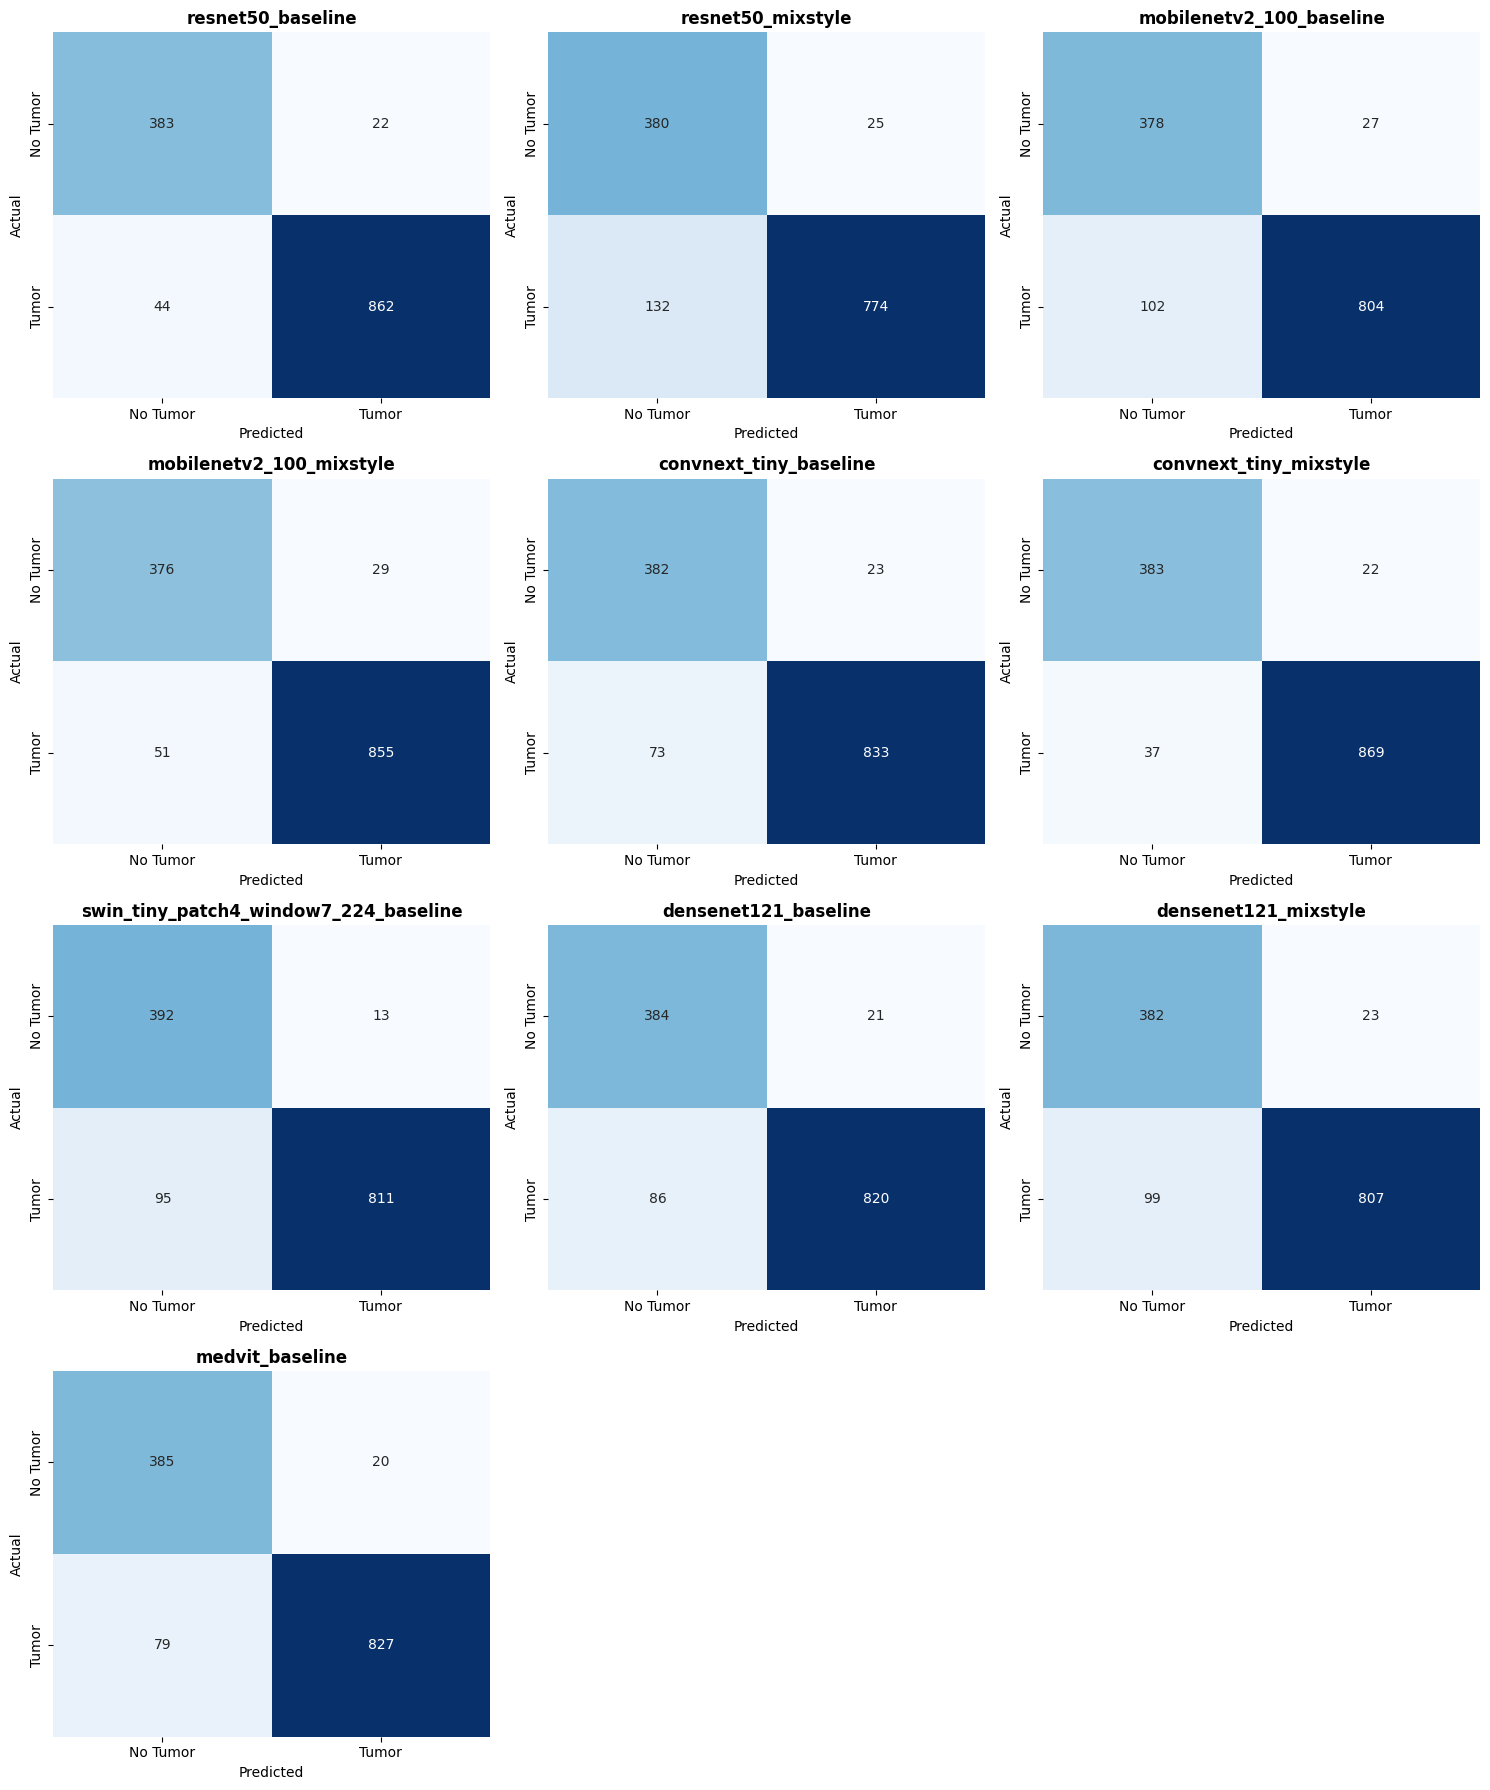


✅ Combined grid saved to: /content/drive/MyDrive/Journal_paper/confusion_matrix/all_models_confusion_matrix_grid.png


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "/content/drive/MyDrive/Journal_paper"
perf_dir = f"{base_dir}/results"
save_dir = f"{base_dir}/confusion_matrix"
os.makedirs(save_dir, exist_ok=True)

file = "all_model_evaluation_BR35H_train_BTD_test.csv"
csv_path = os.path.join(perf_dir, file)
df = pd.read_csv(csv_path)

# Auto-detect model column name (in case 'Unnamed: 0' differs)
model_col = df.columns[0]
labels = ["No Tumor", "Tumor"]

print(f"✅ Loaded file: {file}")
print(f"📊 Detected model name column: '{model_col}'")

def parse_cm(raw):
    try:
        nums = re.findall(r"\d+", str(raw))
        nums = list(map(int, nums))
        if len(nums) == 4:
            return np.array(nums).reshape(2, 2)
        else:
            raise ValueError("Invalid confusion matrix format.")
    except Exception as e:
        print(f"⚠️ Could not parse confusion matrix: {raw} ({e})")
        return np.zeros((2, 2), dtype=int)


all_cms = {}
for idx, row in df.iterrows():
    model_name = str(row[model_col])
    cm_raw = row["confusion_matrix"]
    cm = parse_cm(cm_raw)

    all_cms[model_name] = cm

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=1, linecolor="gray", square=True)

    plt.title(f"{model_name} – Confusion Matrix", fontsize=13, fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=11)
    plt.ylabel("Actual Label", fontsize=11)
    plt.tight_layout()

    # Save each heatmap as PNG
    save_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ Saved confusion matrix: {save_path}")

n_models = len(all_cms)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for i, (model_name, cm) in enumerate(all_cms.items()):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    ax.set_title(model_name, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
grid_path = os.path.join(save_dir, "all_models_confusion_matrix_grid.png")
plt.savefig(grid_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✅ Combined grid saved to: {grid_path}")


In [ ]:

# Grad-CAM for Transformer Models (Generalized)

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

def visualize_grad_cam(
    model, loader, target_class=None,
    layer_name=None, num_images=3, device=None
):
    """
    Visualize Grad-CAM heatmaps for Transformer-based models (ViT, Swin, MedViT, ConvNeXt hybrid).
    Args:
        model: torch model
        loader: dataloader
        target_class: int or None — class index to focus on
        layer_name: str or None — specific layer name, auto-detected if None
        num_images: int — number of images to visualize
        device: torch.device
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval().to(device)
    images, labels = next(iter(loader))


    # Automatically detect a transformer block/norm layer if not given

    if layer_name is None:
        possible_layers = [n for n, _ in model.named_modules() if "blocks" in n or "norm" in n]
        if possible_layers:
            layer_name = possible_layers[-1]
        else:
            layer_name = list(model.named_modules())[-1][0]
        print(f"⚙️ Using automatically detected layer: {layer_name}")


    # Iterate through selected images

    for i in range(min(num_images, len(images))):
        image = images[i].unsqueeze(0).to(device)
        label = labels[i].item()

        gradients, activations = {}, {}

        # Define hooks
        def save_gradients(module, grad_input, grad_output):
            gradients['value'] = grad_output[0]

        def save_activations(module, input, output):
            activations['value'] = output

        # Register hooks
        target_layer = dict(model.named_modules())[layer_name]
        fwd_hook = target_layer.register_forward_hook(save_activations)
        bwd_hook = target_layer.register_full_backward_hook(save_gradients)

        # Forward + backward
        output = model(image)
        pred_class = output.argmax().item() if target_class is None else target_class

        model.zero_grad()
        output[0, pred_class].backward()


        # Extract Grad & Activation

        grad = gradients['value'][0].detach().cpu().numpy()
        act = activations['value'][0].detach().cpu().numpy()

        weights = grad.mean(axis=(1, 2)) if grad.ndim == 3 else grad.mean(axis=0)
        cam = np.zeros(act.shape[1:], dtype=np.float32)

        for j, w in enumerate(weights):
            cam += w * act[j]

        cam = np.maximum(cam, 0)
        cam /= cam.max() + 1e-8


        # Resize & Overlay

        cam_resized = cv2.resize(cam, (image.shape[3], image.shape[2]))
        img_np = image[0].detach().cpu().permute(1, 2, 0).numpy()

        # Denormalize (assuming ImageNet stats)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        overlay = 0.5 * heatmap / 255.0 + 0.5 * img_np


        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f"GT: {label} | Pred: {pred_class} | Layer: {layer_name}", fontsize=11)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        # Clean up hooks
        fwd_hook.remove()
        bwd_hook.remove()


In [ ]:
import pandas as pd

flat_results = {}
for model_name, metrics in results.items():
    # Keep only scalar metrics (accuracy, f1, precision, recall)
    flat_results[model_name] = {k: v for k, v in metrics.items() if k != "confusion_matrix"}

df_results = pd.DataFrame(flat_results).T
df_results.to_csv("/content/drive/MyDrive/Journal_paper/results/cross_dataset_ablation_results.csv")
print("Saved flattened results to CSV")
df_results


Saved flattened results to CSV


accuracy precision    recall        f1  \
resnet50_baseline                      0.949657  0.936034  0.948557  0.950013   
resnet50_mixstyle                      0.880244  0.855449  0.896288  0.883473   
mobilenetv2_100_baseline               0.901602  0.877505  0.910375  0.903647   
mobilenetv2_100_mixstyle               0.938978  0.923878  0.936052   0.93941   
convnext_tiny_baseline                 0.926773  0.906346  0.931318  0.927863   
convnext_tiny_mixstyle                 0.954996  0.943607   0.95242  0.955217   
swin_tiny_patch4_window7_224_baseline   0.91762  0.894576  0.931522  0.919454   
densenet121_baseline                   0.918383  0.896026  0.926613  0.919896   
densenet121_mixstyle                   0.906941  0.883234  0.916969  0.908895   
medvit_baseline                        0.924485  0.903064   0.93171  0.925778   

                                                                                  y_true  \
resnet50_baseline                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
resnet50_mixstyle                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_baseline               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_mixstyle               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_baseline                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_mixstyle                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
swin_tiny_patch4_window7_224_baseline  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_baseline                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_mixstyle                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
medvit_baseline                                                                      NaN   

                                                                                  y_pred  \
resnet50_baseline                      [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
resnet50_mixstyle                      [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
mobilenetv2_100_baseline               [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
mobilenetv2_100_mixstyle               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_baseline                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
convnext_tiny_mixstyle                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
swin_tiny_patch4_window7_224_baseline  [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
densenet121_baseline                   [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
densenet121_mixstyle                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...   
medvit_baseline                                                                      NaN   

                                                                        y_probs_positive  
resnet50_baseline                      [0.48943892, 0.94241, 0.8589587, 0.99681324, 0...  
resnet50_mixstyle                      [0.5252826, 0.8500992, 0.72172797, 0.9893918, ...  
mobilenetv2_100_baseline               [0.9998909, 0.9999931, 0.8918704, 0.84256995, ...  
mobilenetv2_100_mixstyle               [0.9999989, 0.99998224, 0.9984022, 0.99999774,...  
convnext_tiny_baseline                 [0.98475075, 0.9999043, 0.99505204, 0.9993568,...  
convnext_tiny_mixstyle                 [0.98561734, 0.9997578, 0.99965894, 0.9983254,...  
swin_tiny_patch4_window7_224_baseline  [0.99962723, 0.9993468, 0.9955041, 0.9959235, ...  
densenet121_baseline                   [0.9896556, 0.9430524, 0.9001143, 0.969507, 0....  
densenet121_mixstyle                   [0.98566914, 0.9900034, 0.9457991, 0.9771922, ...  
medvit_baseline                                                                      NaN

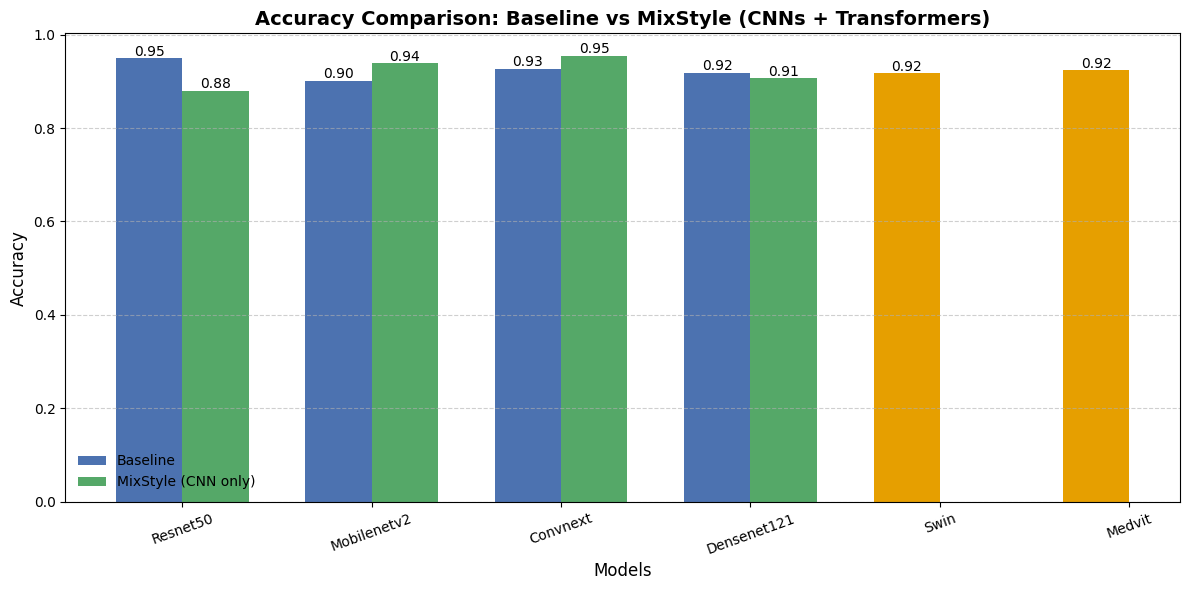

✅ Saved plot for accuracy: /content/drive/MyDrive/Journal_paper/results/plots/accuracy_baseline_vs_mixstyle_all_models.png


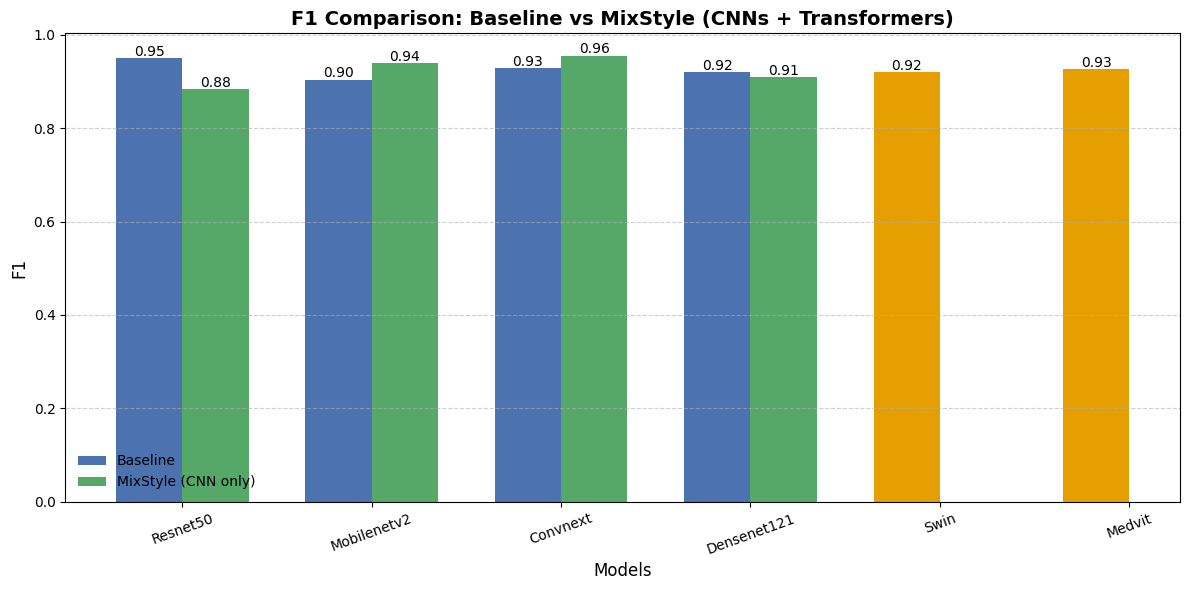

✅ Saved plot for f1: /content/drive/MyDrive/Journal_paper/results/plots/f1_baseline_vs_mixstyle_all_models.png


In [ ]:

#Comparison Plots – All Models (CNN + Transformer)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

results_path = "/content/drive/MyDrive/Journal_paper/results/all_model_evaluation_BR35H_train_BTD_test.csv"
df = pd.read_csv(results_path, index_col=0)


cnn_models = ["resnet50", "mobilenetv2_100", "convnext_tiny", "densenet121"]
transformer_models = ["swin_tiny_patch4_window7_224", "medvit"]

metrics = ["accuracy", "f1"]

save_dir = "/content/drive/MyDrive/Journal_paper/results/plots"
os.makedirs(save_dir, exist_ok=True)

for metric in metrics:
    plt.figure(figsize=(12, 6))

    x_labels, baseline_vals, mixstyle_vals, model_types = [], [], [], []

    # Collect CNN results
    for m in cnn_models:
        base_key, mix_key = f"{m}_baseline", f"{m}_mixstyle"
        if base_key in df.index:
            baseline_vals.append(df.loc[base_key, metric])
        else:
            baseline_vals.append(np.nan)
        if mix_key in df.index:
            mixstyle_vals.append(df.loc[mix_key, metric])
        else:
            mixstyle_vals.append(np.nan)
        x_labels.append(m.replace("_100", "").replace("_tiny", "").capitalize())
        model_types.append("CNN")

    # Collect Transformer results (Baseline only)
    for m in transformer_models:
        base_key = f"{m}_baseline"
        if base_key in df.index:
            baseline_vals.append(df.loc[base_key, metric])
        else:
            baseline_vals.append(np.nan)
        mixstyle_vals.append(np.nan)  # No MixStyle for transformers
        x_labels.append(m.replace("_tiny_patch4_window7_224", "").capitalize())
        model_types.append("Transformer")

    x = np.arange(len(x_labels))
    width = 0.35

    # Separate color schemes for CNNs and Transformers
    baseline_colors = ["#4C72B0" if t == "CNN" else "#E69F00" for t in model_types]
    mixstyle_colors = ["#55A868" if t == "CNN" else "#E69F00" for t in model_types]

    plt.bar(x - width/2, baseline_vals, width, label="Baseline", color=baseline_colors)
    plt.bar(x + width/2, mixstyle_vals, width, label="MixStyle (CNN only)", color=mixstyle_colors)

    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.title(f"{metric.capitalize()} Comparison: Baseline vs MixStyle (CNNs + Transformers)", fontsize=14, fontweight="bold")
    plt.xticks(x, x_labels, rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend(frameon=False)

    # Add numeric labels
    for i, v in enumerate(baseline_vals):
        if not np.isnan(v):
            plt.text(x[i] - width/2, v + 0.005, f"{v:.2f}", ha="center", fontsize=10)
    for i, v in enumerate(mixstyle_vals):
        if not np.isnan(v):
            plt.text(x[i] + width/2, v + 0.005, f"{v:.2f}", ha="center", fontsize=10)

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(save_dir, f"{metric}_baseline_vs_mixstyle_all_models.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Saved plot for {metric}: {save_path}")


✅ Loaded model: convnext_tiny_mixstyle from /content/drive/MyDrive/Journal_paper/checkpoints/convnext_tiny_mixstyle_best.pth


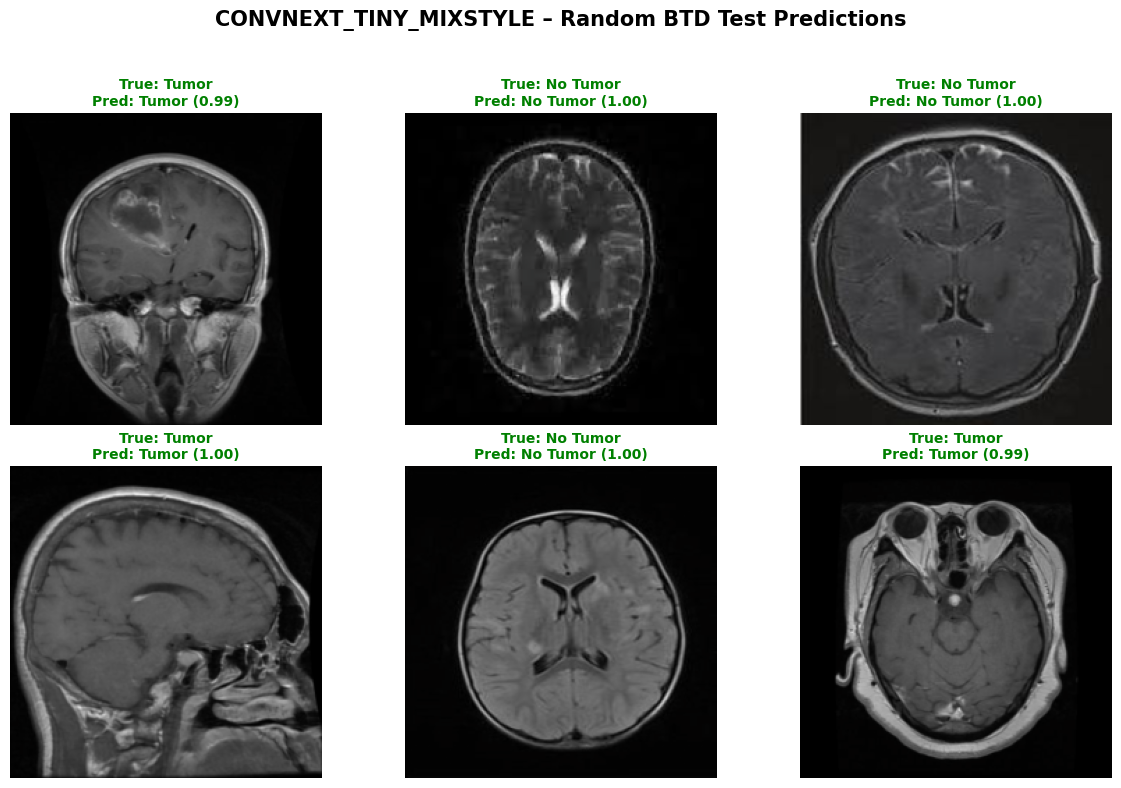

✅ Saved prediction visualization → /content/drive/MyDrive/Journal_paper/predictions/convnext_tiny_mixstyle_BTD_Predictions.png


In [ ]:

#  Prediction Visualization (5–6 Random Test Images)

import os
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# ✅ Setup
base_dir = "/content/drive/MyDrive/Journal_paper"
checkpoint_dir = f"{base_dir}/checkpoints"
save_dir = f"{base_dir}/predictions"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Select the model name you want to visualize
best_model_name = "convnext_tiny_mixstyle"
num_classes = 2

# ✅ Load the model dynamically
model_path = os.path.join(checkpoint_dir, f"{best_model_name}_best.pth")
model = get_model(best_model_name.replace("_baseline", "").replace("_mixstyle", ""),
                  num_classes=num_classes,
                  use_mixstyle="mixstyle" in best_model_name)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print(f"✅ Loaded model: {best_model_name} from {model_path}")

# ✅ Helper: Unnormalize image
def unnormalize(img_tensor):
    img = img_tensor.clone().cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    return img

# ✅ Class names (binary BTD)
class_names = ["No Tumor", "Tumor"]

# ✅ Randomly select 6 samples from test dataset
num_images = 6
indices = random.sample(range(len(test_ds_binary)), num_images)
images = [test_ds_binary[i][0] for i in indices]
labels = [test_ds_binary[i][1] for i in indices]

# ✅ Run predictions
with torch.no_grad():
    inputs = torch.stack(images).to(device)
    outputs = model(inputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    confs, preds = torch.max(probs, 1)

# ✅ Visualization
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.suptitle(f"{best_model_name.upper()} – Random BTD Test Predictions", fontsize=15, fontweight="bold")

for i, ax in enumerate(axes.flatten()):
    if i >= num_images:
        ax.axis("off")
        continue

    img = unnormalize(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i].item()]
    conf = confs[i].item()

    color = "green" if true_label == pred_label else "red"
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf:.2f})", color=color, fontsize=10, fontweight="bold")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# ✅ Save the visualization
save_path = os.path.join(save_dir, f"{best_model_name}_BTD_Predictions.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved prediction visualization → {save_path}")



🔍 Evaluating ROC for: resnet50_baseline
✅ resnet50_baseline: Acc=0.9497, F1=0.9500, AUC=0.9773

🔍 Evaluating ROC for: resnet50_mixstyle
✅ resnet50_mixstyle: Acc=0.8802, F1=0.8835, AUC=0.9655

🔍 Evaluating ROC for: mobilenetv2_100_baseline
✅ mobilenetv2_100_baseline: Acc=0.9016, F1=0.9036, AUC=0.9630

🔍 Evaluating ROC for: mobilenetv2_100_mixstyle
✅ mobilenetv2_100_mixstyle: Acc=0.9390, F1=0.9394, AUC=0.9777

🔍 Evaluating ROC for: convnext_tiny_baseline
✅ convnext_tiny_baseline: Acc=0.9268, F1=0.9279, AUC=0.9789

🔍 Evaluating ROC for: convnext_tiny_mixstyle
✅ convnext_tiny_mixstyle: Acc=0.9550, F1=0.9552, AUC=0.9770

🔍 Evaluating ROC for: swin_tiny_patch4_window7_224_baseline
✅ swin_tiny_patch4_window7_224_baseline: Acc=0.9176, F1=0.9195, AUC=0.9802

🔍 Evaluating ROC for: densenet121_baseline
✅ densenet121_baseline: Acc=0.9184, F1=0.9199, AUC=0.9777

🔍 Evaluating ROC for: densenet121_mixstyle
✅ densenet121_mixstyle: Acc=0.9069, F1=0.9089, AUC=0.9699

🔍 Evaluating ROC for: medvit_baseli

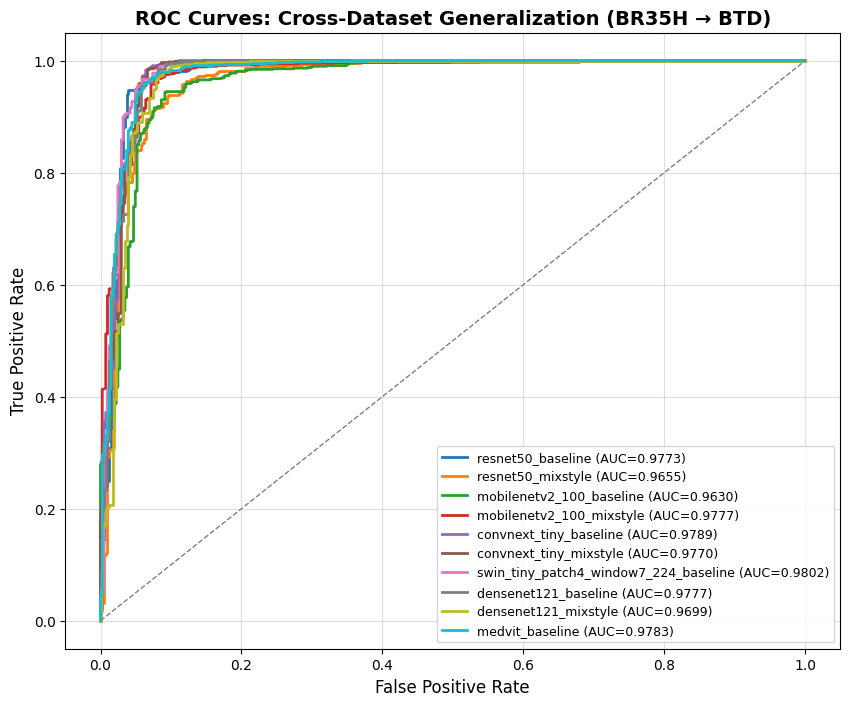


✅ Combined ROC plot saved to: /content/drive/MyDrive/Journal_paper/results_with_ROC/All_Models_ROC_Comparison.png
📁 Final scalar metrics with AUC saved to: /content/drive/MyDrive/Journal_paper/results_with_ROC/final_scalar_metrics_with_ROC.csv


accuracy precision    recall        f1  \
resnet50_baseline                      0.949657  0.936034  0.948557  0.950013   
resnet50_mixstyle                      0.880244  0.855449  0.896288  0.883473   
mobilenetv2_100_baseline               0.901602  0.877505  0.910375  0.903647   
mobilenetv2_100_mixstyle               0.938978  0.923878  0.936052   0.93941   
convnext_tiny_baseline                 0.926773  0.906346  0.931318  0.927863   
convnext_tiny_mixstyle                 0.954996  0.943607   0.95242  0.955217   
swin_tiny_patch4_window7_224_baseline   0.91762  0.894576  0.931522  0.919454   
densenet121_baseline                   0.918383  0.896026  0.926613  0.919896   
densenet121_mixstyle                   0.906941  0.883234  0.916969  0.908895   
medvit_baseline                        0.924485  0.903064   0.93171  0.925778   

                                                                        y_probs_positive  \
resnet50_baseline                      [0.48943892, 0.94241, 0.8589587, 0.99681324, 0...   
resnet50_mixstyle                      [0.5252826, 0.8500992, 0.72172797, 0.9893918, ...   
mobilenetv2_100_baseline               [0.9998909, 0.9999931, 0.8918704, 0.84256995, ...   
mobilenetv2_100_mixstyle               [0.9999989, 0.99998224, 0.9984022, 0.99999774,...   
convnext_tiny_baseline                 [0.98475075, 0.9999043, 0.99505204, 0.9993568,...   
convnext_tiny_mixstyle                 [0.98561734, 0.9997578, 0.99965894, 0.9983254,...   
swin_tiny_patch4_window7_224_baseline  [0.99962723, 0.9993468, 0.9955041, 0.9959235, ...   
densenet121_baseline                   [0.9896556, 0.9430524, 0.9001143, 0.969507, 0....   
densenet121_mixstyle                   [0.98566914, 0.9900034, 0.9457991, 0.9771922, ...   
medvit_baseline                        [0.9935753, 0.8994284, 0.99882, 0.9918527, 0.0...   

                                            AUC  
resnet50_baseline                      0.977342  
resnet50_mixstyle                      0.965533  
mobilenetv2_100_baseline               0.962953  
mobilenetv2_100_mixstyle               0.977681  
convnext_tiny_baseline                 0.978897  
convnext_tiny_mixstyle                 0.976979  
swin_tiny_patch4_window7_224_baseline  0.980198  
densenet121_baseline                   0.977699  
densenet121_mixstyle                   0.969863  
medvit_baseline                        0.978294

In [ ]:

# ROC-AUC Evaluation and Combined Plot for All Models
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms

# --- Setup ---
img_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# --- Paths ---
base_dir = "/content/drive/MyDrive/Journal_paper"
checkpoint_dir = f"{base_dir}/checkpoints"
perf_dir = os.path.join(base_dir, "results_with_ROC")
os.makedirs(perf_dir, exist_ok=True)

# --- Test Dataset ---
btd_root = "/content/drive/MyDrive/Data/Brain Tumor Data"
test_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
btd_test_ds = ImageFolder(f"{btd_root}/test", transform=test_tfms)

# Binary BTD label mapping
btd_label_map = {0: 1, 1: 1, 2: 0, 3: 1}

class BinaryBTDDataset(Dataset):
    def __init__(self, dataset, mapped_labels):
        self.dataset = dataset
        self.labels = mapped_labels
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, self.labels[idx]

btd_test_labels = [btd_label_map[label] for _, label in btd_test_ds.imgs]
test_loader_binary = DataLoader(
    BinaryBTDDataset(btd_test_ds, btd_test_labels),
    batch_size=32, shuffle=False, num_workers=2
)

# --- Model Map (All Architectures) ---
model_arch_map = {
    "resnet50": "resnet50",
    "mobilenetv2_100": "mobilenetv2_100",
    "convnext_tiny": "convnext_tiny",
    "densenet121": "densenet121",
    "swin_tiny_patch4_window7_224": "swin_tiny_patch4_window7_224",
    "medvit": "medvit"
}

# --- Storage ---
final_results_with_roc = {}
roc_data = {}

# --- Evaluation Loop ---
for ckpt_file in os.listdir(checkpoint_dir):
    if not ckpt_file.endswith("_best.pth"):
        continue

    model_name = ckpt_file.replace("_best.pth", "")
    ckpt_path = os.path.join(checkpoint_dir, ckpt_file)

    # Determine architecture
    arch_key = model_name.split("_baseline")[0].split("_mixstyle")[0]
    model_arch_name = model_arch_map.get(arch_key)
    if not model_arch_name:
        continue

    use_mixstyle = "mixstyle" in model_name

    print(f"\n🔍 Evaluating ROC for: {model_name}")

    # Load model
    model = get_model(model_arch_name, num_classes=num_classes, use_mixstyle=use_mixstyle).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # Collect predictions
    all_labels, all_probs = [], []
    with torch.no_grad():
        for x, y in test_loader_binary:
            x = x.to(device)
            y = y.to(device)
            preds = model(x)
            probs = torch.softmax(preds, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(y.cpu().numpy())

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    roc_data[model_name] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}

    # Get additional metrics
    metrics = evaluate_model(model, test_loader_binary)
    metrics["AUC"] = roc_auc
    final_results_with_roc[model_name] = metrics

    print(f"✅ {model_name}: Acc={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, AUC={roc_auc:.4f}")

# --- Combined ROC Plot ---
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(roc_data)))

for (m, data), color in zip(roc_data.items(), colors):
    plt.plot(data["fpr"], data["tpr"], lw=2, color=color, label=f"{m} (AUC={data['auc']:.4f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves: Cross-Dataset Generalization (BR35H → BTD)", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.4)

roc_comp_path = os.path.join(perf_dir, "All_Models_ROC_Comparison.png")
plt.savefig(roc_comp_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✅ Combined ROC plot saved to: {roc_comp_path}")

# --- Save Results to CSV ---
df_roc_results = pd.DataFrame(final_results_with_roc).T
df_roc_results_scalar = df_roc_results.drop(columns=["confusion_matrix", "y_true", "y_pred"], errors="ignore")
final_csv_path = os.path.join(perf_dir, "final_scalar_metrics_with_ROC.csv")
df_roc_results_scalar.to_csv(final_csv_path)

print(f"📁 Final scalar metrics with AUC saved to: {final_csv_path}")
display(df_roc_results_scalar)


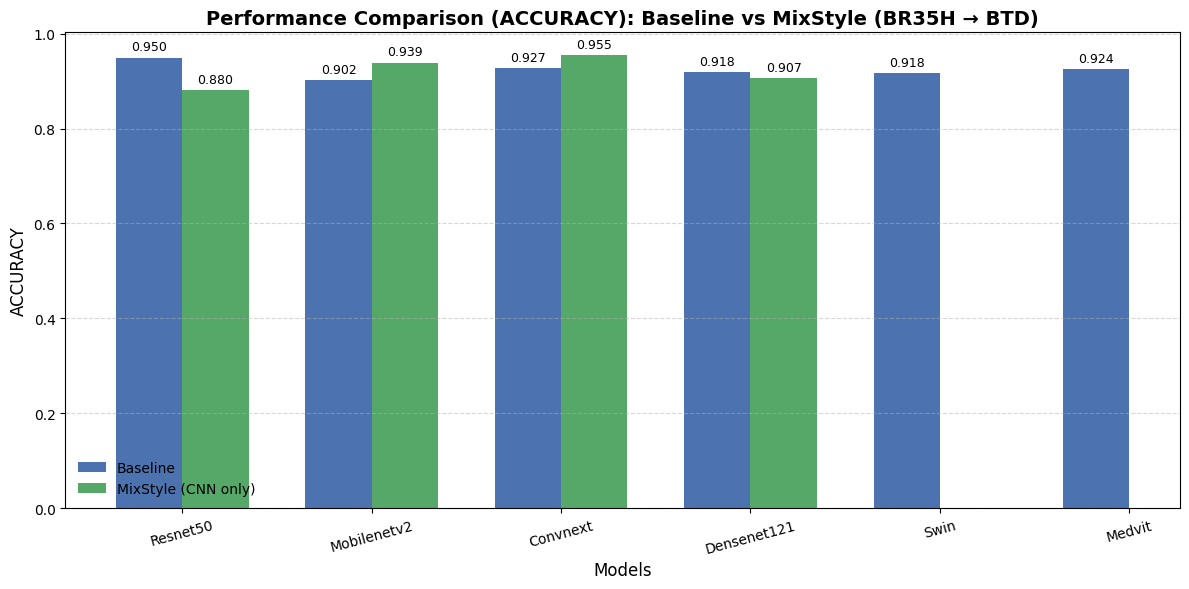

✅ Saved plot for accuracy: /content/drive/MyDrive/Journal_paper/results_with_ROC/comparison_plots/All_Models_accuracy_Comparison.png


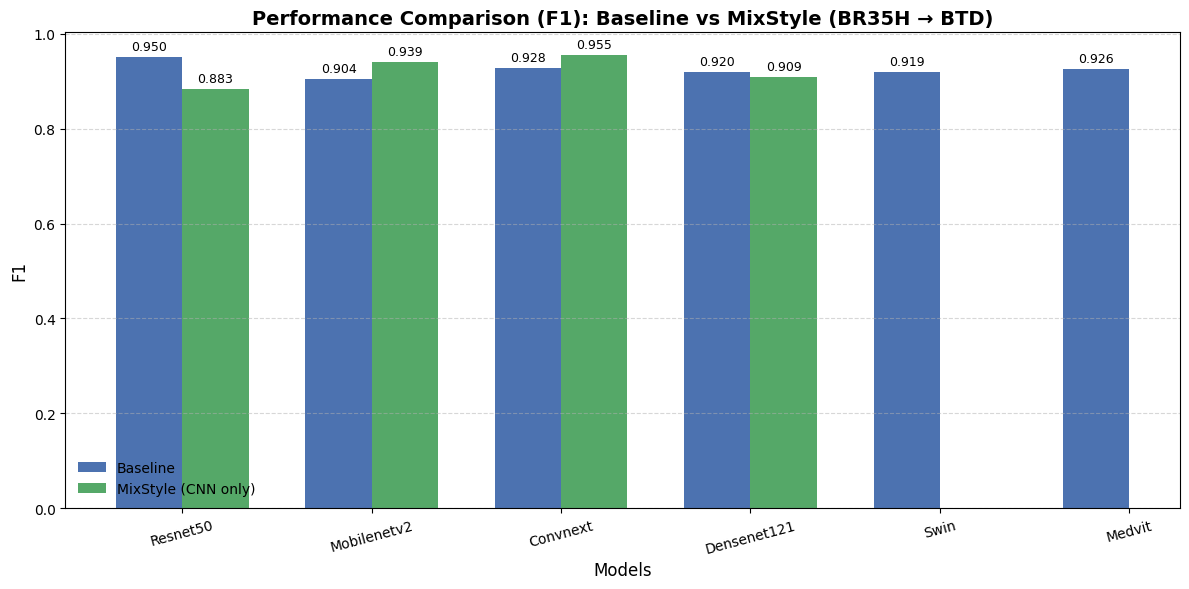

✅ Saved plot for f1: /content/drive/MyDrive/Journal_paper/results_with_ROC/comparison_plots/All_Models_f1_Comparison.png


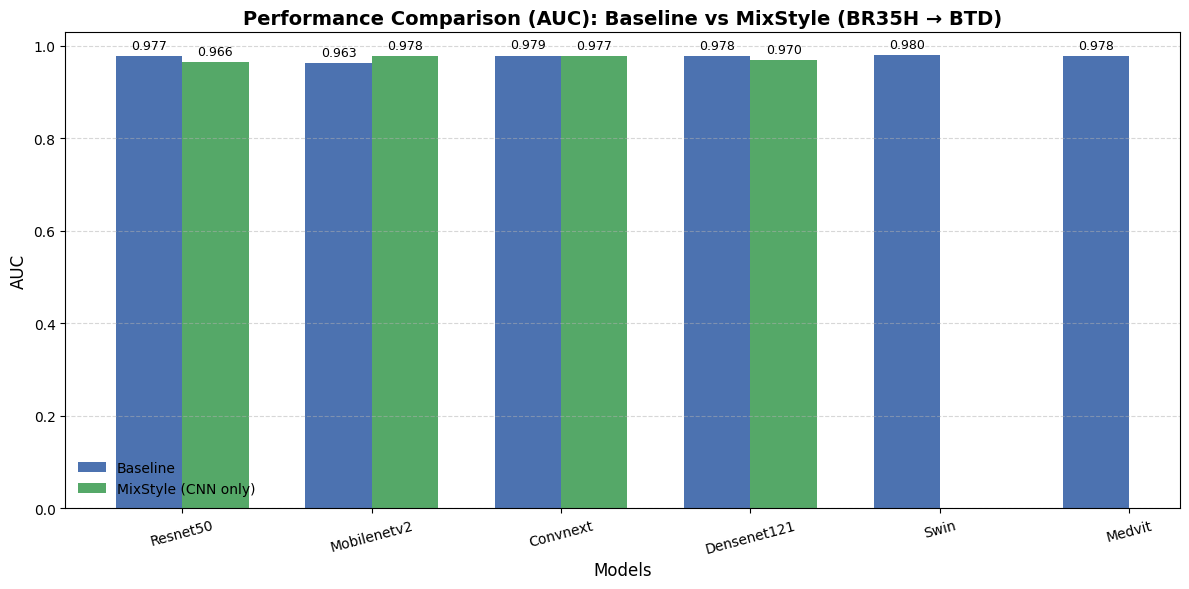

✅ Saved plot for AUC: /content/drive/MyDrive/Journal_paper/results_with_ROC/comparison_plots/All_Models_AUC_Comparison.png


In [ ]:

# All Models – Baseline vs MixStyle Performance Comparison

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

results_dir = "/content/drive/MyDrive/Journal_paper/results_with_ROC"
csv_path = os.path.join(results_dir, "final_scalar_metrics_with_ROC.csv")
df_results = pd.read_csv(csv_path, index_col=0)

cnn_models = ["resnet50", "mobilenetv2_100", "convnext_tiny", "densenet121"]
transformer_models = ["swin_tiny_patch4_window7_224", "medvit"]

metrics = ["accuracy", "f1", "AUC"]
save_dir = os.path.join(results_dir, "comparison_plots")
os.makedirs(save_dir, exist_ok=True)

for metric in metrics:
    plt.figure(figsize=(12, 6))

    x_labels = []
    baseline_vals = []
    mixstyle_vals = []

    # CNN models (with MixStyle)
    for m in cnn_models:
        base_key = f"{m}_baseline"
        mix_key = f"{m}_mixstyle"

        baseline_vals.append(df_results.loc[base_key, metric] if base_key in df_results.index else np.nan)
        mixstyle_vals.append(df_results.loc[mix_key, metric] if mix_key in df_results.index else np.nan)
        x_labels.append(m.replace("_100", "").replace("_tiny", "").capitalize())

    # Transformer + MedViT models (Baseline only)
    for m in transformer_models:
        base_key = f"{m}_baseline"
        baseline_vals.append(df_results.loc[base_key, metric] if base_key in df_results.index else np.nan)
        mixstyle_vals.append(np.nan)  # no MixStyle for transformers
        x_labels.append(m.replace("_tiny_patch4_window7_224", "").capitalize())

    # X-axis
    x = np.arange(len(x_labels))
    width = 0.35

    # Bar plotting
    rects1 = plt.bar(x - width/2, baseline_vals, width, label="Baseline", color="#4C72B0")
    rects2 = plt.bar(x + width/2, mixstyle_vals, width, label="MixStyle (CNN only)", color="#55A868")

    # Label formatting
    def autolabel(rects, vals):
        for rect, val in zip(rects, vals):
            if np.isnan(val): continue
            height = rect.get_height()
            plt.annotate(f"{val:.3f}",
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=9)

    autolabel(rects1, baseline_vals)
    autolabel(rects2, mixstyle_vals)

    # Styling
    plt.ylabel(metric.upper(), fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.title(f"Performance Comparison ({metric.upper()}): Baseline vs MixStyle (BR35H → BTD)", fontsize=14, fontweight="bold")
    plt.xticks(x, x_labels, rotation=15)
    plt.legend(frameon=False)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Save figure
    save_path = os.path.join(save_dir, f"All_Models_{metric}_Comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Saved plot for {metric}: {save_path}")



🔥 Visualizing resnet50 Grad-CAM


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

🔍 Using layer: layer4 for resnet50


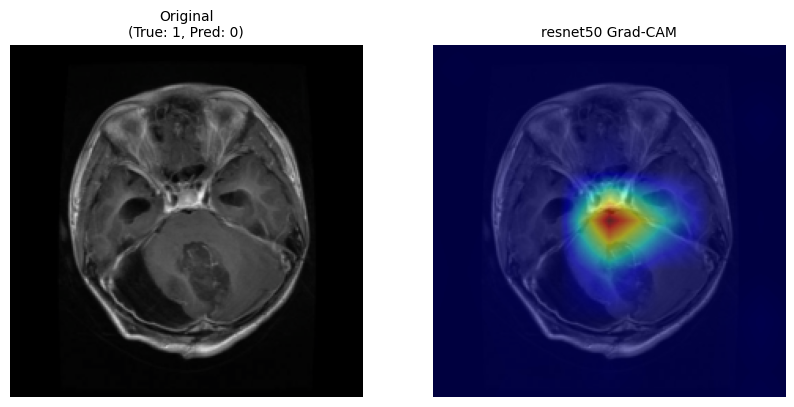

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/resnet50_sample0.png


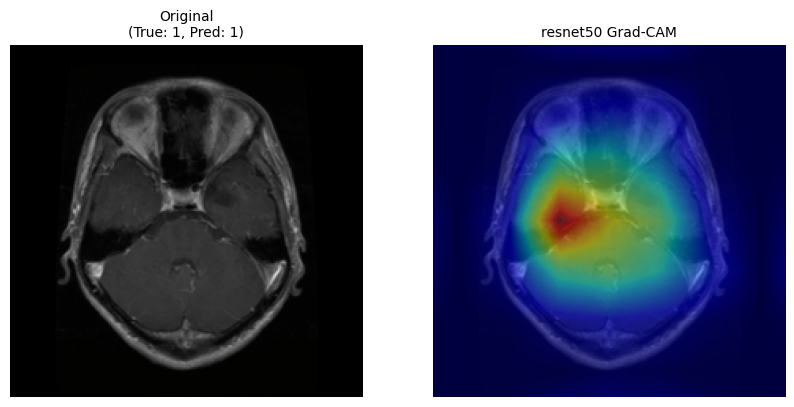

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/resnet50_sample1.png

🔥 Visualizing mobilenetv2_100 Grad-CAM


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

⚠️ Layer 'features.17' not found in mobilenetv2_100. Check model.named_modules().
⏩ Skipping mobilenetv2_100: layer not found.

🔥 Visualizing convnext_tiny Grad-CAM


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🔍 Using layer: stages.3.blocks.2.norm for convnext_tiny


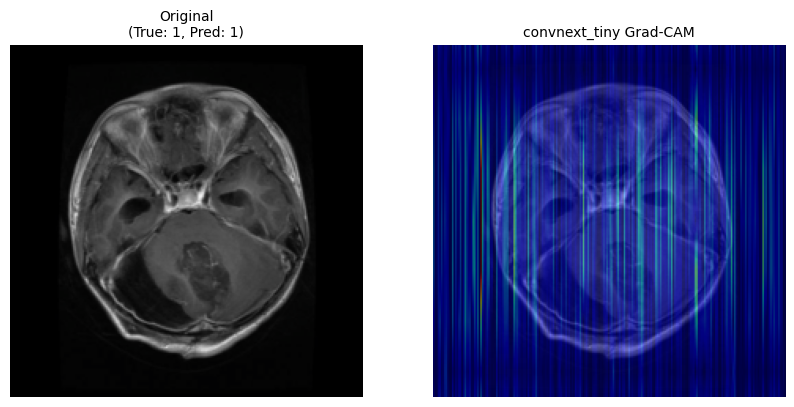

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/convnext_tiny_sample0.png


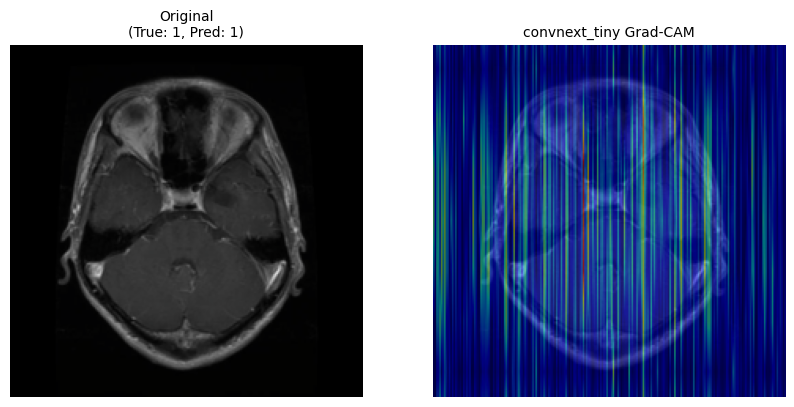

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/convnext_tiny_sample1.png

🔥 Visualizing densenet121 Grad-CAM


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

🔍 Using layer: features.norm5 for densenet121


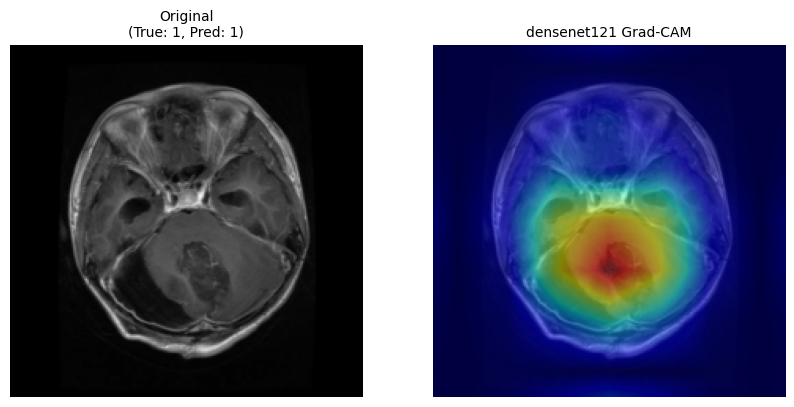

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/densenet121_sample0.png


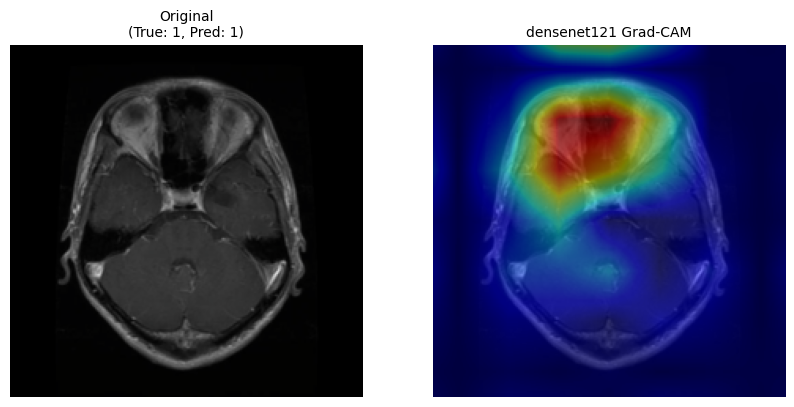

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/densenet121_sample1.png

🔥 Visualizing swin_tiny_patch4_window7_224 Grad-CAM


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🔍 Using layer: layers.3.blocks.1.norm1 for swin_tiny_patch4_window7_224


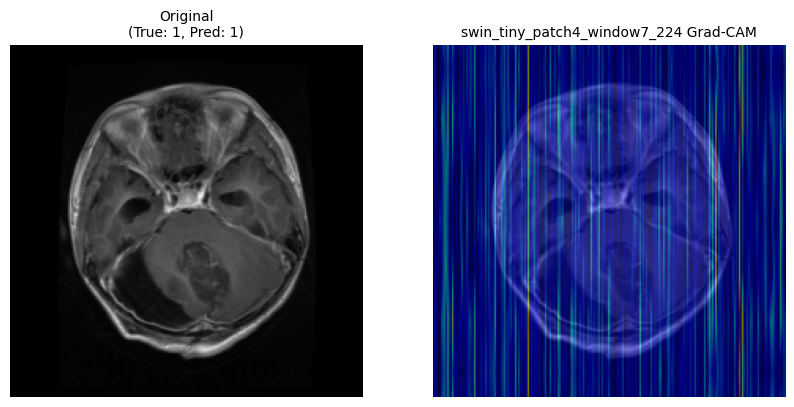

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/swin_tiny_patch4_window7_224_sample0.png


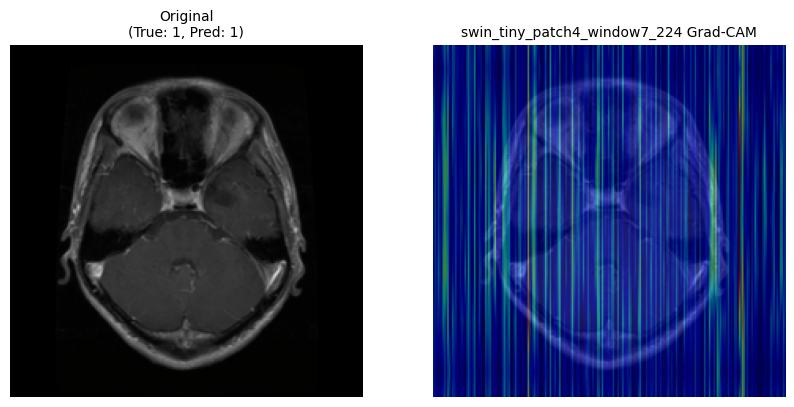

✅ Saved Grad-CAM: /content/drive/MyDrive/Journal_paper/visuals/gradcam_all_models/swin_tiny_patch4_window7_224_sample1.png

🔥 Visualizing medvit Grad-CAM


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

⚠️ Layer 'stem.norm' not found in medvit. Check model.named_modules().
⏩ Skipping medvit: layer not found.


In [ ]:

# Universal Grad-CAM for All Models (CNN + Transformer + MedViT)

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Directories ---
base_dir = "/content/drive/MyDrive/Journal_paper"
checkpoint_dir = f"{base_dir}/checkpoints"
cam_dir = f"{base_dir}/visuals/gradcam_all_models"
os.makedirs(cam_dir, exist_ok=True)

# --- Layer selection map ---
def get_last_conv_layer(model, model_name):
    """Auto-select appropriate visualization layer per architecture"""
    layer_candidates = {
        "resnet50": "layer4",
        "mobilenetv2_100": "features.17",
        "convnext_tiny": "stages.3.blocks.2.norm",
        "densenet121": "features.norm5",
        "swin_tiny_patch4_window7_224": "layers.3.blocks.1.norm1",
        "medvit": "stem.norm"  # adjust if medvit has patch_embed.norm
    }

    target_layer_name = layer_candidates.get(model_name)
    if not target_layer_name:
        print(f"⚠️ Unknown model {model_name}, please specify a layer.")
        return None, None

    try:
        layer = dict([*model.named_modules()])[target_layer_name]
        return layer, target_layer_name
    except KeyError:
        print(f"⚠️ Layer '{target_layer_name}' not found in {model_name}. Check model.named_modules().")
        return None, None

# --- Grad-CAM Visualization ---
def visualize_grad_cam(model, loader, model_name, num_images=2):
    model.eval()
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])

    layer, layer_name = get_last_conv_layer(model, model_name)
    if layer is None:
        print(f"⏩ Skipping {model_name}: layer not found.")
        return

    print(f"🔍 Using layer: {layer_name} for {model_name}")
    images, labels = next(iter(loader))

    for i in range(min(num_images, len(images))):
        image = images[i].unsqueeze(0).to(device)
        label = labels[i].item()

        gradients, activations = {}, {}

        def save_gradients(module, grad_input, grad_output):
            gradients["value"] = grad_output[0].detach()

        def save_activations(module, input, output):
            activations["value"] = output.detach()

        fh = layer.register_forward_hook(save_activations)
        bh = layer.register_full_backward_hook(save_gradients)

        # Forward + backward
        output = model(image)
        pred = output.argmax(dim=1).item()
        model.zero_grad()
        output[0, pred].backward()

        fh.remove()
        bh.remove()

        grad = gradients["value"][0].cpu().numpy()
        act = activations["value"][0].cpu().numpy()

        # Compute Grad-CAM
        weights = grad.mean(axis=(1, 2)) if grad.ndim == 3 else grad.mean(axis=0)
        cam = np.zeros(act.shape[1:], dtype=np.float32)
        for j, w in enumerate(weights):
            cam += w * act[j]
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() if cam.max() != 0 else cam

        # Resize & overlay
        cam = resize(cam, (images.shape[2], images.shape[3]))
        img_np = images[i].cpu().numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np * STD + MEAN, 0, 1)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        plt.title(f"Original\n(True: {label}, Pred: {pred})", fontsize=10)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_np)
        plt.imshow(cam, cmap="jet", alpha=0.5)
        plt.title(f"{model_name} Grad-CAM", fontsize=10)
        plt.axis("off")

        save_path = os.path.join(cam_dir, f"{model_name}_sample{i}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"✅ Saved Grad-CAM: {save_path}")

# --- Run Grad-CAM for All Models ---
model_names = [
    "resnet50",
    "mobilenetv2_100",
    "convnext_tiny",
    "densenet121",
    "swin_tiny_patch4_window7_224",
    "medvit"
]

for name in model_names:
    model_path = os.path.join(checkpoint_dir, f"{name}_baseline_best.pth")
    if not os.path.exists(model_path):
        print(f"⚠️ Skipping {name}: checkpoint not found.")
        continue

    print(f"\n🔥 Visualizing {name} Grad-CAM")
    model = get_model(name, num_classes=2, use_mixstyle=False).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    visualize_grad_cam(model, test_loader_binary, name)



--- Processing resnet50_baseline ---


Extracting features for resnet50_baseline: 100%|██████████| 41/41 [00:09<00:00,  4.42it/s]


✅ t-SNE completed for resnet50_baseline

--- Processing mobilenetv2_100_baseline ---


Extracting features for mobilenetv2_100_baseline: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]


✅ t-SNE completed for mobilenetv2_100_baseline

--- Processing convnext_tiny_baseline ---


Extracting features for convnext_tiny_baseline: 100%|██████████| 41/41 [00:10<00:00,  4.09it/s]


✅ t-SNE completed for convnext_tiny_baseline

--- Processing densenet121_baseline ---


Extracting features for densenet121_baseline: 100%|██████████| 41/41 [00:09<00:00,  4.25it/s]


✅ t-SNE completed for densenet121_baseline

--- Processing swin_tiny_patch4_window7_224_baseline ---


Extracting features for swin_tiny_patch4_window7_224_baseline: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]


✅ t-SNE completed for swin_tiny_patch4_window7_224_baseline

--- Processing medvit_baseline ---


Extracting features for medvit_baseline: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]


✅ t-SNE completed for medvit_baseline


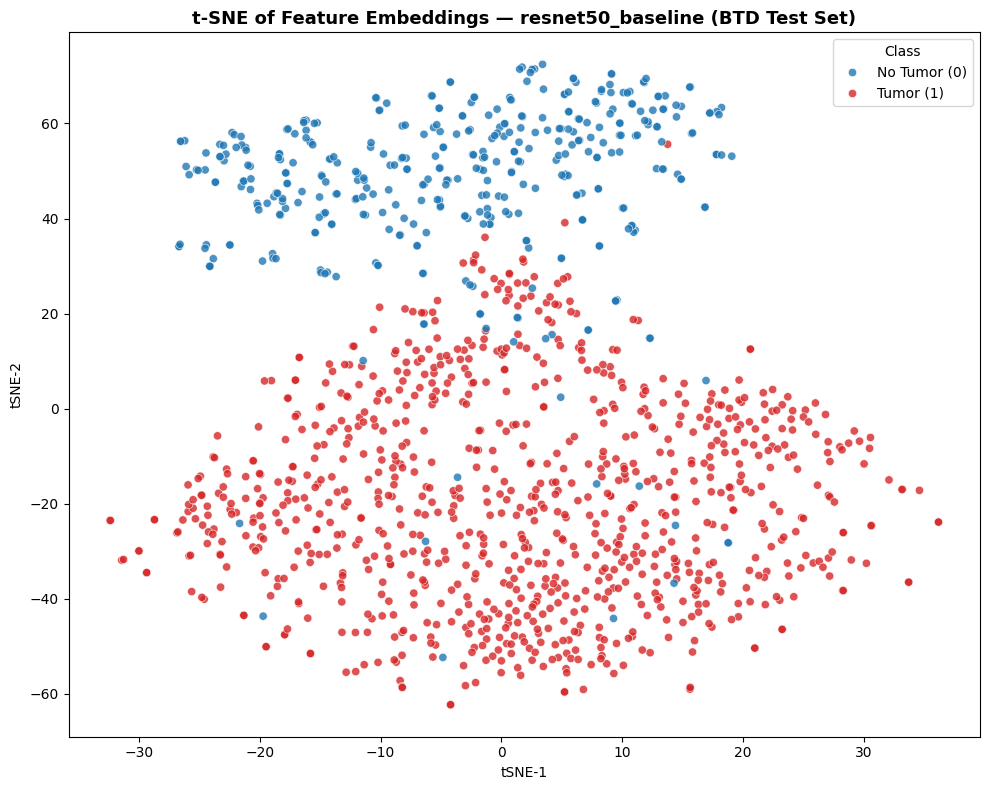

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/resnet50_baseline_tSNE_Feature_Space.png


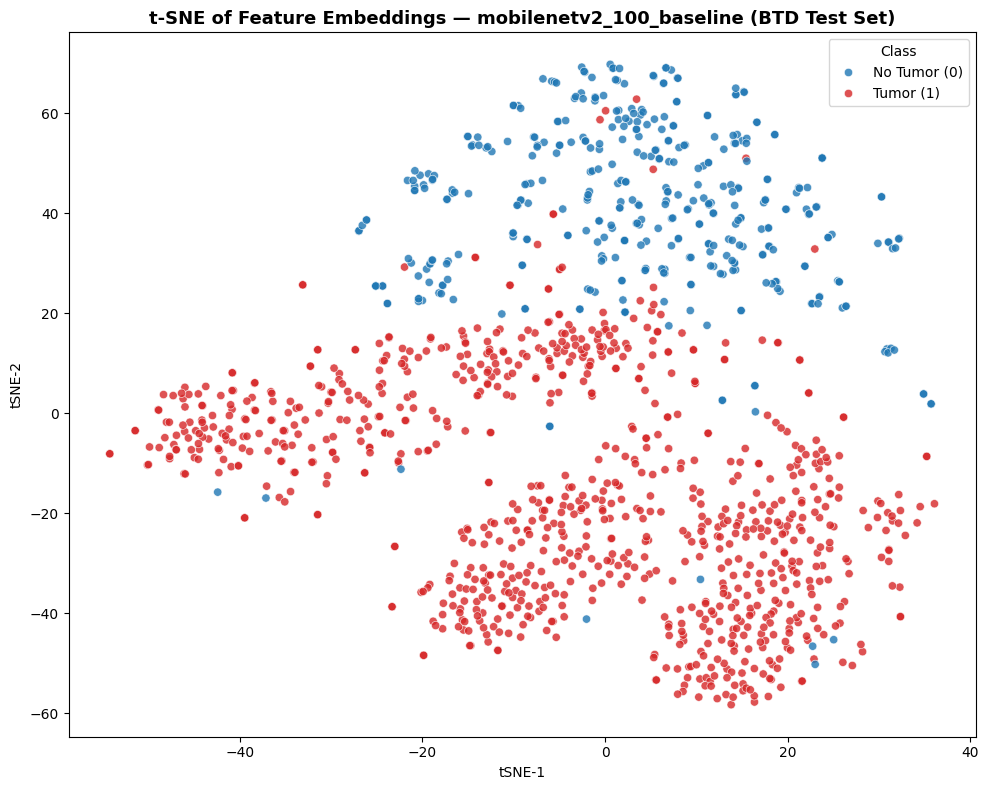

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/mobilenetv2_100_baseline_tSNE_Feature_Space.png


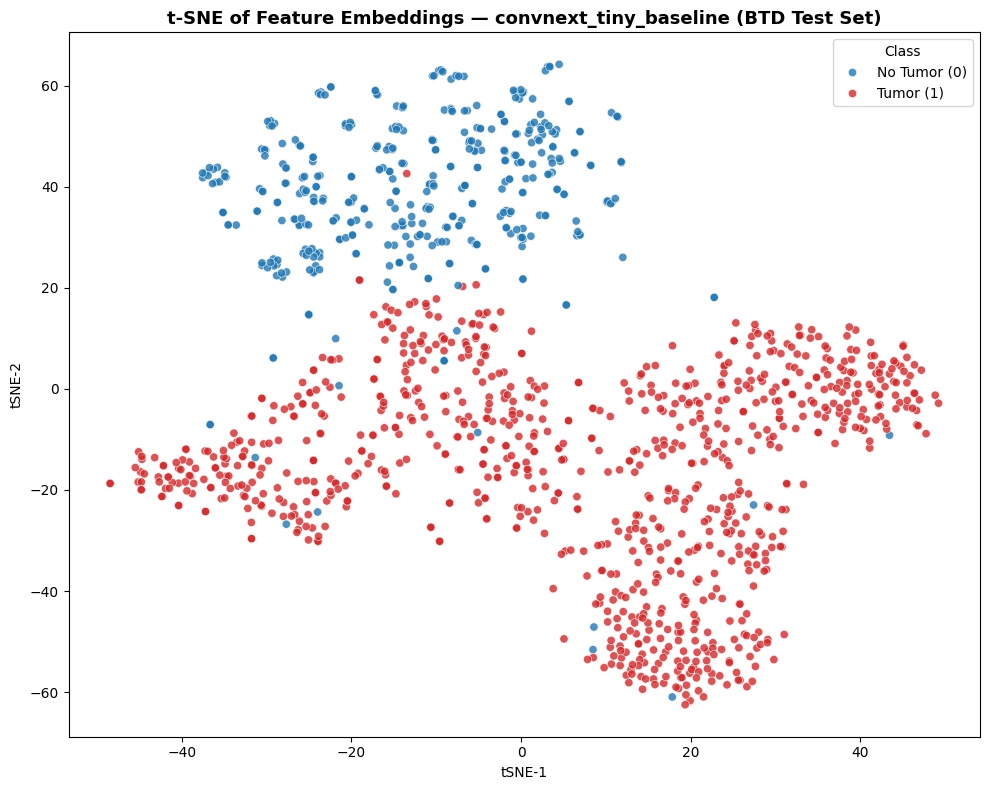

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/convnext_tiny_baseline_tSNE_Feature_Space.png


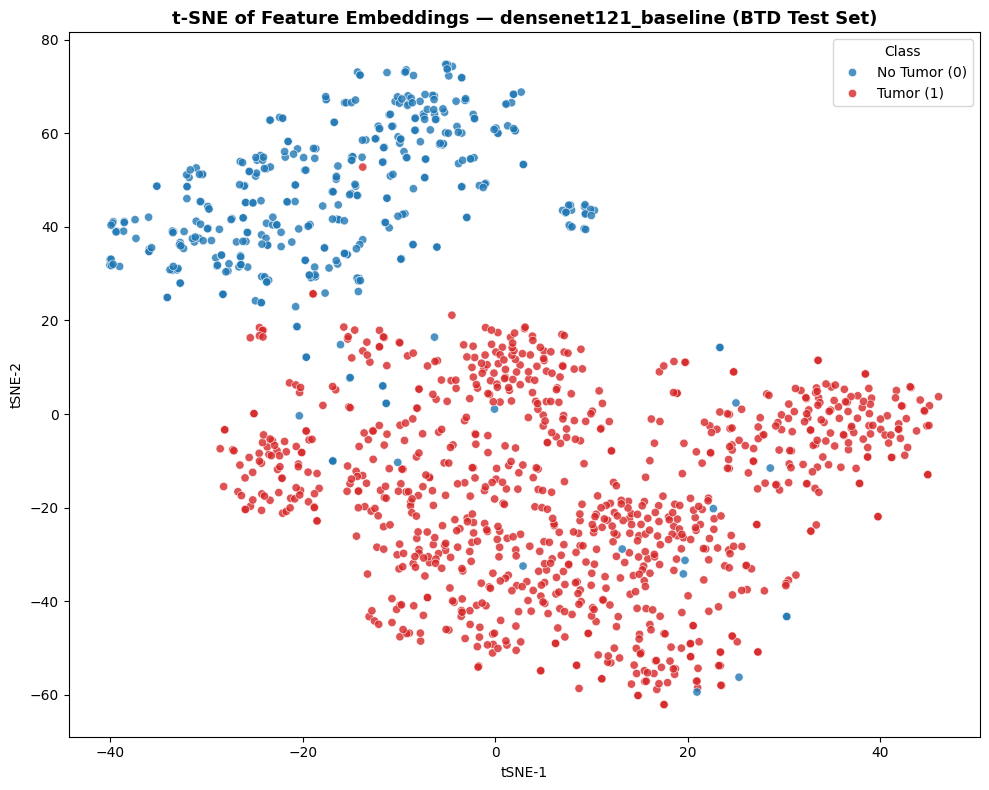

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/densenet121_baseline_tSNE_Feature_Space.png


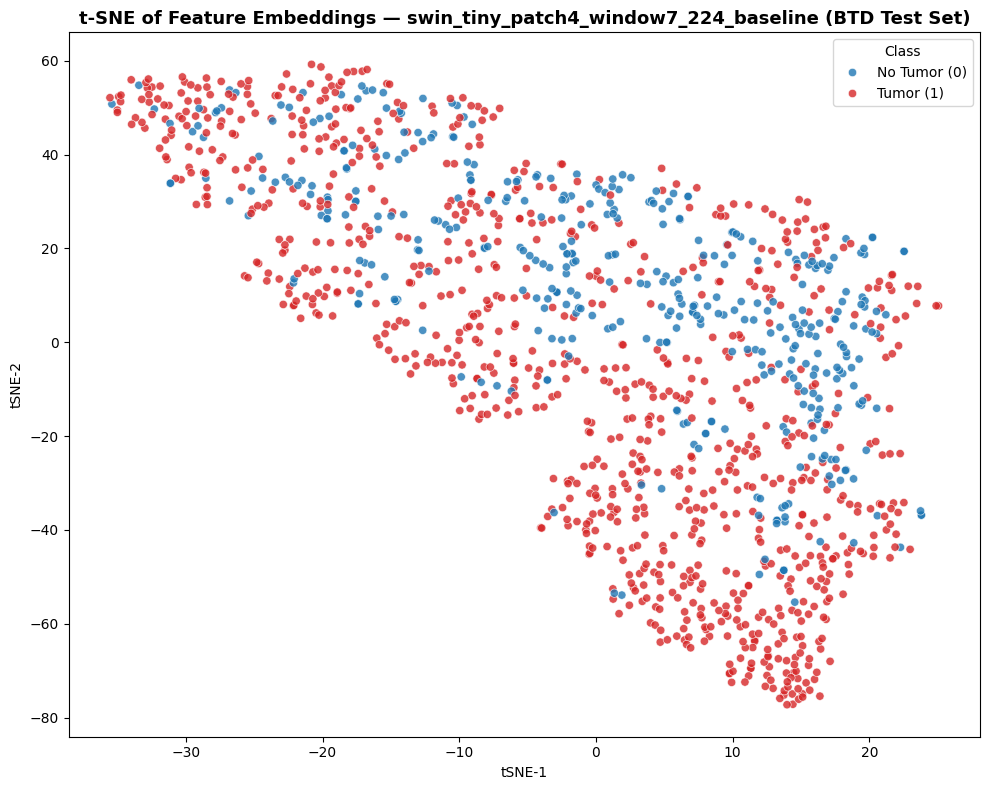

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/swin_tiny_patch4_window7_224_baseline_tSNE_Feature_Space.png


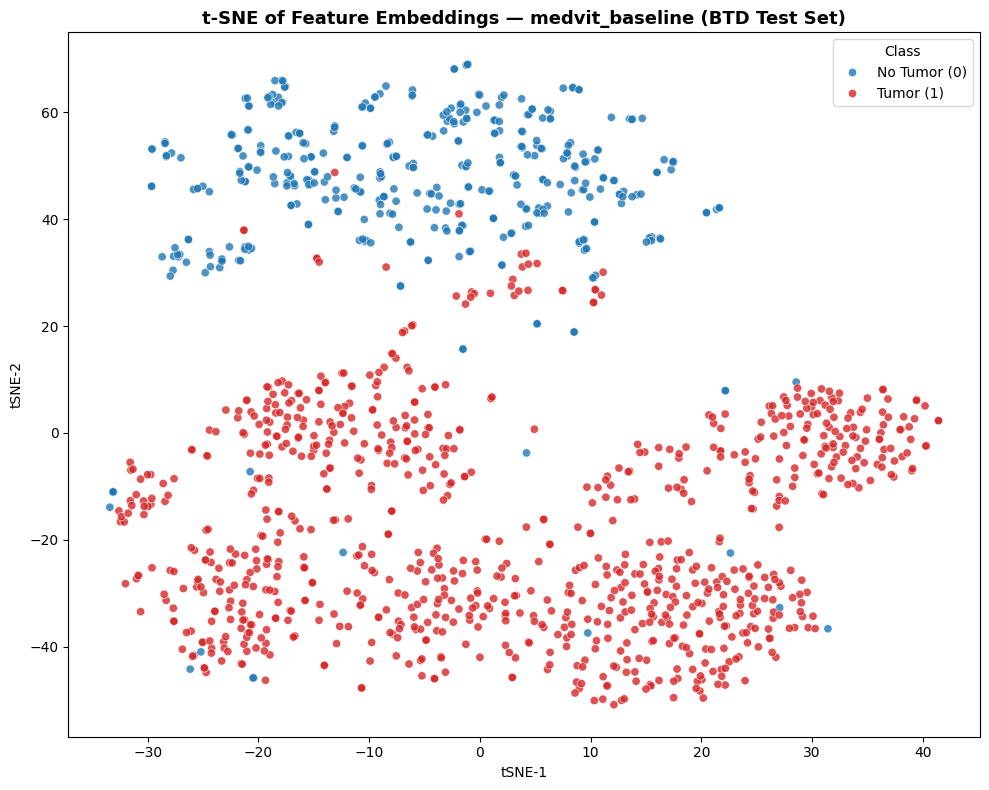

📊 Saved t-SNE plot → /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations/medvit_baseline_tSNE_Feature_Space.png

✅ All t-SNE visualizations saved to: /content/drive/MyDrive/Journal_paper/results_with_ROC/tSNE_visualizations


In [ ]:

# Cell: Universal t-SNE Visualization for All Models (CNN + Transformer + MedViT)

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE


def get_features(model, loader, device):
    """
    Extracts features from the layer just before final classification.
    Works for CNNs and Transformers.
    """
    model.eval()
    all_labels = []
    features_list = []

    # Identify appropriate feature extraction layer
    if hasattr(model, "fc"):                  # ResNet
        target_layer = model.fc
    elif hasattr(model, "classifier"):        # MobileNet / DenseNet
        target_layer = model.classifier
    elif hasattr(model, "head"):              # ConvNeXt / Swin / ViT / MedViT
        target_layer = model.head
    else:
        print(f"❌ Could not find a suitable feature layer in {getattr(model, 'name', 'Unknown')}")
        return None, None

    def hook_fn(module, input, output):
        # Capture the layer input (pre-classification features)
        features_list.append(input[0].detach().cpu().numpy())

    hook = target_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for x, y in tqdm(loader, desc=f"Extracting features for {getattr(model, 'name', 'Unknown')}"):
            x = x.to(device)
            _ = model(x)
            all_labels.extend(y.cpu().numpy())

    hook.remove()

    if not features_list:
        print(f"⚠️ No features extracted for {getattr(model, 'name', 'Unknown')}")
        return None, None

    all_features = np.concatenate(features_list, axis=0)

    # Shape normalization (GAP if spatial features)
    if all_features.ndim == 4:
        all_features = all_features.mean(axis=(2, 3))
    elif all_features.ndim == 3:
        all_features = all_features.mean(axis=2)
    elif all_features.ndim > 4:
        all_features = all_features.reshape(all_features.shape[0], -1)

    return all_features, np.array(all_labels)

MODELS_TO_PLOT = {
    "resnet50_baseline": "resnet50",
    "mobilenetv2_100_baseline": "mobilenetv2_100",
    "convnext_tiny_baseline": "convnext_tiny",
    "densenet121_baseline": "densenet121",
    "swin_tiny_patch4_window7_224_baseline": "swin_tiny_patch4_window7_224",
    "medvit_baseline": "medvit"
}

tsne = TSNE(
    n_components=2, random_state=42,
    perplexity=30, learning_rate="auto",
    init="random"
)

all_tsne_data = []
save_dir = os.path.join(perf_dir, "tSNE_visualizations")
os.makedirs(save_dir, exist_ok=True)

for model_name, model_arch in MODELS_TO_PLOT.items():
    print(f"\n--- Processing {model_name} ---")
    ckpt_path = os.path.join(checkpoint_dir, f"{model_name}_best.pth")

    if not os.path.exists(ckpt_path):
        print(f"⚠️ Skipping {model_name}: checkpoint not found.")
        continue

    # Load model
    model = get_model(model_arch, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.name = model_name

    # Extract features
    features, labels = get_features(model, test_loader_binary, device)
    if features is None or len(features) < 10:
        print(f"⚠️ Skipping t-SNE for {model_name}: insufficient features")
        continue

    # Compute t-SNE
    tsne_results = tsne.fit_transform(features)
    df_tsne = pd.DataFrame(tsne_results, columns=["tSNE-1", "tSNE-2"])
    df_tsne["Label"] = labels
    df_tsne["Model"] = model_name
    all_tsne_data.append(df_tsne)

    print(f"✅ t-SNE completed for {model_name}")

class_names = ["No Tumor (0)", "Tumor (1)"]

for df_tsne in all_tsne_data:
    model_name = df_tsne["Model"].iloc[0]
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="tSNE-1", y="tSNE-2",
        hue="Label",
        palette=["#1f77b4", "#d62728"],  # blue / red
        data=df_tsne,
        legend="full",
        alpha=0.8
    )

    # Fix legend
    handles, labels_ = plt.gca().get_legend_handles_labels()
    label_map = {"0": class_names[0], "1": class_names[1]}
    mapped_labels = [label_map.get(l, l) for l in labels_]
    plt.legend(handles, mapped_labels, title="Class")

    plt.title(f"t-SNE of Feature Embeddings — {model_name} (BTD Test Set)", fontsize=13, fontweight="bold")
    plt.xlabel("tSNE-1")
    plt.ylabel("tSNE-2")
    plt.tight_layout()

    tsne_path = os.path.join(save_dir, f"{model_name}_tSNE_Feature_Space.png")
    plt.savefig(tsne_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"📊 Saved t-SNE plot → {tsne_path}")

print(f"\n✅ All t-SNE visualizations saved to: {save_dir}")
